# 1. Import & Installation

In [621]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-pr/item_properties_part2 (1).csv
/kaggle/input/final-pr/item_properties_part1.csv
/kaggle/input/final-pr/category_tree.csv
/kaggle/input/final-pr/events.csv


In [622]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import datetime as dt
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy
from itertools import cycle
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import sys
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit

# 2. Functions

In [649]:
def feature_distribution(df, feat, clr):
    fig, axs = plt.subplots(1, 2, figsize=(18, 3))
    axs[0].hist(df[feat], bins=20, histtype='bar', orientation='vertical', color=clr)
    axs[0].set_title(feat, fontsize=15)
    axs[1].boxplot(df[feat], vert=False)
    fig.show()
    
    
def get_property(item):
    value = set(items_df.loc[items_df.itemid==item]['property'].to_list())
    return value

def get_value(item):
    value = set(items_df.loc[items_df.itemid==item]['value'].to_list())
    return value

def get_parentid(item):
    value = set(items_df.loc[items_df.itemid==item]['parentid'].to_list())
    return value

###Baseline prediction function
def baseline_3_top(num):
    prediction = set(supertop_3)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict   

###Df prediction function
def get_prediction(us_list, pred_function):
    prediction_df = {'visitorid': us_list}
    prediction_df = pd.DataFrame.from_dict(prediction_df)
    prediction_df['prediction'] = prediction_df['visitorid'].map(pred_function)
    prediction_df['purch_number'] = prediction_df['visitorid'].apply(lambda x: len(test.loc[test.visitorid==x]))
    prediction_df['precision@3'] = round((prediction_df['prediction']/3),4)
    
    return prediction_df  

In [650]:
#Prediction by similar USERS generation (Cosine similarity)
def cos_vis_items(num):
    
    ### 1. Similar users from matrix
    
    #Index for the desired user
    visitor_index = cos_VISITORS_df.loc[cos_VISITORS_df.visitorid==num].index.tolist()[0]
    #Similar users generation
    similar_visitors = list(enumerate(cosine_sim_vis[visitor_index]))
    #Sorting the Similar Visitors List in Descending Order
    sorted_similar_visitors = sorted(similar_visitors, key=lambda x:x[1], reverse=True) 
    #5 nearest visitors, first - the same
    sorted_similar_visitors = sorted_similar_visitors[1:6]
    #Transforming to frame
    sorted_similar_visitors = pd.DataFrame(sorted_similar_visitors)
    sorted_similar_visitors = sorted_similar_visitors[0].tolist() #Indices!!! not users :)
    similar_visitors = user_index_cos.loc[user_index_cos.index.isin(sorted_similar_visitors)]
    similar_visitors = similar_visitors.visitorid.to_list()
    
    ### 2. Items generation
    
    cols = ['visitorid', 'itemid', 'event']
    purchased_items = user_features[cols]
    purchased_items = purchased_items.loc[(purchased_items.event=='transaction')&(purchased_items.visitorid.isin(similar_visitors))]
    purchased_items = purchased_items.itemid.unique().tolist() #unique items
    
    ### 3. Items filtering by rating
    #3.1. Similar users rating
    cols = ['visitorid', 'itemid', 'event']
    vis_items_rating = user_features[cols]
    cols = ['visitorid', 'itemid', 'event']
    sim_vis_items_rating = user_features[cols]
    sim_vis_items_rating = sim_vis_items_rating.loc[(sim_vis_items_rating.visitorid.isin(similar_visitors))&(
                                                     sim_vis_items_rating.itemid.isin(purchased_items))]
    
    score_dict = {'transaction': 5,
                  'addtocart': 2,
                  'view': 1}
    sim_vis_items_rating['score'] = sim_vis_items_rating['event'].map(score_dict)

    sim_vis_items_rating = pd.pivot_table(sim_vis_items_rating,
                        values = 'score', 
                        index = ['visitorid', 'itemid'],
                        aggfunc=np.sum)
    sim_vis_items_rating = sim_vis_items_rating.reset_index() #initial users rating
    
    #3.2. Desired visitor's backlog rating    
    sing_vis_items_rating = user_features[cols]
    sing_vis_items_rating = sing_vis_items_rating.loc[(sing_vis_items_rating.visitorid==num)&(
                                                 sing_vis_items_rating.itemid.isin(purchased_items))]

    sing_vis_items_rating['score'] = sing_vis_items_rating['event'].map(score_dict)

    sing_vis_items_rating = pd.pivot_table(sing_vis_items_rating,
                        values = 'score', 
                        index = ['itemid'],
                        aggfunc=np.sum)

    sing_vis_items_rating = sing_vis_items_rating.reset_index()
    
    #3.3. Final rating (similar users + desired visitor)
    common_rating = sim_vis_items_rating.merge(sing_vis_items_rating, on='itemid', how='left')

    columns_count = common_rating.shape[1]

    if columns_count==3:
        common_rating['sing_score']=0
    else:
        common_rating['sing_score']=common_rating['score_y']
    
    common_rating['final'] = common_rating[common_rating.columns[2]]+common_rating['sing_score']
    common_rating = common_rating.sort_values(by='final', ascending=False)
    pred_items_user = common_rating[0:3]['itemid'].to_list()

    ### 4. Prediction checking
    prediction = set(pred_items_user)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict

In [651]:
#Prediction by similar ITEMS generation (Cosine similarity)
def cos_items_items(num):
    
    ### 1. Similar items from matrix
    purchased_items = item_features.loc[(item_features.visitorid==num)&(item_features.event=='transaction')]['itemid'].to_list()
    item_index = cos_ITEMS_df.loc[cos_ITEMS_df.itemid.isin(purchased_items)].index.tolist()
    
    #Items list iteration
    iteration_range = len(item_index)
    frame = pd.DataFrame()

    for i in range(iteration_range):
        similar_items = list(enumerate(cosine_sim_itm[item_index][i]))
        sorted_similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
        sorted_similar_items = sorted_similar_items[1:6]
        sorted_similar_items = pd.DataFrame(sorted_similar_items, columns=['index', 'score'])
        items_list = []
        for j in sorted_similar_items['index']:
            itemid = item_index_cos.iloc[j][0]
            items_list.append(itemid)
            sorted_similar_items['itemid'] = pd.DataFrame(items_list)
        frame = pd.concat([frame,sorted_similar_items])
    
    frame = frame.groupby(by='itemid').sum().reset_index()[['itemid', 'score']]
    frame = frame.rename(columns={'score': 'similarity_score'})
    similarity_frame = frame
    
    ### 2. Items filtering by rating
    # 2.1.  All users events filter / как все пользователи взаимодействовали с этими товарами
    similar_items = similarity_frame.itemid.unique().tolist()
    
    cols = ['itemid','add_item', 'trans_item', 'view_item', 'repeat_count', 'top_20_sale', 'top_month_sale']
    common_items_rating = item_features[cols].loc[item_features.itemid.isin(similar_items)]
    common_items_rating['add_scores'] = common_items_rating['add_item']*2
    common_items_rating['view_scores'] = common_items_rating['view_item']
    common_items_rating['trans_scores'] = common_items_rating['trans_item']*5
    common_items_rating['repeat_scores'] = common_items_rating['repeat_count']*10
    common_items_rating['top_scores'] = (common_items_rating['top_20_sale']+common_items_rating['top_month_sale'])*10
    common_items_rating = common_items_rating.drop_duplicates().fillna(0).reset_index(drop=True)
    score_cols = common_items_rating.columns[7:]
    common_items_rating['score'] = common_items_rating[score_cols].sum(axis=1)
    
    # 2.3. User's rating / как пользователь взаимодействовал с товарами
    cols = ['visitorid', 'itemid', 'event']

    score_dict = {'transaction': 25,
              'addtocart': 10,
              'view': 5}

    sing_vis_items_rating = user_features[cols]
    sing_vis_items_rating = sing_vis_items_rating.loc[(sing_vis_items_rating.visitorid==num)&(
                                                  sing_vis_items_rating.itemid.isin(similar_items))] #frame

    sing_vis_items_rating['score'] = sing_vis_items_rating['event'].map(score_dict)

    sing_vis_items_rating = pd.pivot_table(sing_vis_items_rating,
                        values = 'score', 
                        index = ['itemid'],
                        aggfunc=np.sum)

    sing_vis_items_rating = sing_vis_items_rating.reset_index()
    
    #3.3. Final rating (similar items + desired visitor + similarity)
    common_rating = common_items_rating.merge(sing_vis_items_rating, on='itemid', how='left')

    columns_count = common_rating.shape[1]

    if columns_count==13:
        common_rating['sing_score']=0
    else:
        common_rating['sing_score']=common_rating['score_y']
    
    common_rating['final'] = common_rating[common_rating.columns[12]]+common_rating['sing_score']
    
    #Adding similarity score
    common_rating = common_rating.merge(similarity_frame, on='itemid', how='left')
    cols = ['itemid', 'similarity_score', 'final']
    common_rating = common_rating[cols]
    common_rating = common_rating.sort_values(by=['final', 'similarity_score'], ascending=False)
    
    #Predicted items
    pred_items_user = common_rating.itemid[0:3].to_list()

    ### 4. Prediction checking
    prediction = set(pred_items_user)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict 

In [652]:
def simple_mtrx_user(num):
    #Items generation
    usr = user_index.loc[user_index.visitorid==num]['index'].iloc[0]
    prediction = model.recommend(userid=usr, N=3, user_items=user_item_sparse) 
    prediction = pd.DataFrame(prediction, columns=['itemid', 'score'])
    predicted_item_list = prediction.itemid.tolist()
    #Predicting
    prediction = set(predicted_item_list)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict

In [653]:
#Prediction by similar USERS generation (Logistic Matrix Factorization)

def mtrx_vis_items(num):
    
    ### 1. Similar users from matrix
    #Index for desired user
    num = pr_exp_users[0]
    usr = user_index.loc[user_index.visitorid==num]['index'].iloc[0]
    #Similar users generation (5 users)
    similar_users = model.similar_users(userid=usr, N=5)
    similar_users = pd.DataFrame(similar_users, columns=['us_index', 'score'])
    #Indices list
    users_index_list = similar_users.us_index.tolist()
    similar_visitors = user_index.loc[user_index.index.isin(users_index_list)]
    similar_visitors = similar_visitors.visitorid.to_list()
        
    ### 2. Items generation
    
    cols = ['visitorid', 'itemid', 'event']
    purchased_items = user_features[cols]
    purchased_items = purchased_items.loc[(purchased_items.event=='transaction')&(purchased_items.visitorid.isin(similar_visitors))]
    purchased_items = purchased_items.itemid.unique().tolist() #unique items
    
    ### 3. Items filtering by rating
    #3.1. Similar users rating
    cols = ['visitorid', 'itemid', 'event']
    vis_items_rating = user_features[cols]
    cols = ['visitorid', 'itemid', 'event']
    sim_vis_items_rating = user_features[cols]
    sim_vis_items_rating = sim_vis_items_rating.loc[(sim_vis_items_rating.visitorid.isin(similar_visitors))&(
                                                     sim_vis_items_rating.itemid.isin(purchased_items))]
    
    score_dict = {'transaction': 5,
                  'addtocart': 2,
                  'view': 1}
    sim_vis_items_rating['score'] = sim_vis_items_rating['event'].map(score_dict)

    sim_vis_items_rating = pd.pivot_table(sim_vis_items_rating,
                        values = 'score', 
                        index = ['visitorid', 'itemid'],
                        aggfunc=np.sum)
    sim_vis_items_rating = sim_vis_items_rating.reset_index() #initial users rating
    
    #3.2. Desired visitor's backlog rating    
    sing_vis_items_rating = user_features[cols]
    sing_vis_items_rating = sing_vis_items_rating.loc[(sing_vis_items_rating.visitorid==num)&(
                                                 sing_vis_items_rating.itemid.isin(purchased_items))]

    sing_vis_items_rating['score'] = sing_vis_items_rating['event'].map(score_dict)

    sing_vis_items_rating = pd.pivot_table(sing_vis_items_rating,
                        values = 'score', 
                        index = ['itemid'],
                        aggfunc=np.sum)

    sing_vis_items_rating = sing_vis_items_rating.reset_index()
    
    #3.3. Final rating (similar users + desired visitor)
    common_rating = sim_vis_items_rating.merge(sing_vis_items_rating, on='itemid', how='left')

    columns_count = common_rating.shape[1]

    if columns_count==3:
        common_rating['sing_score']=0
    else:
        common_rating['sing_score']=common_rating['score_y']
    
    common_rating['final'] = common_rating[common_rating.columns[2]]+common_rating['sing_score']
    common_rating = common_rating.sort_values(by='final', ascending=False)
    pred_items_user = common_rating[0:3]['itemid'].to_list()

    ### 4. Prediction checking
    prediction = set(pred_items_user)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict

In [654]:
#Prediction by similar ITEMS generation (Logistic Matrix Factorization)
def mtrx_items_items(num):
    
    ### 1. Similar items from matrix
    purchased_items = item_features.loc[(item_features.visitorid==num)&(item_features.event=='transaction')]['itemid'].to_list()
    purchased_item_indices = item_index.loc[item_index.itemid.isin(purchased_items)].index.tolist()
    
    #Items list iteration
    iteration_range = len(purchased_item_indices)
    frame = pd.DataFrame()

    for i in range(iteration_range):
        similar_items = model.similar_items(itemid = purchased_item_indices[i], N=5)
        similar_items = pd.DataFrame(similar_items, columns=['index', 'score'])        
        items_list = []
        for j in similar_items['index']:
                itemid = item_index.iloc[j][1]
                items_list.append(itemid)
                similar_items['itemid'] = pd.DataFrame(items_list)                
        frame = pd.concat([frame,similar_items])
            
    frame = frame.groupby(by='itemid').sum().reset_index()[['itemid', 'score']]
    frame = frame.rename(columns={'score': 'similarity_score'})
    similarity_frame = frame
    
    ### 2. Items filtering by rating
    # 2.1.  All users events filter / как все пользователи взаимодействовали с этими товарами
    similar_items = similarity_frame.itemid.unique().tolist()
    
    cols = ['itemid','add_item', 'trans_item', 'view_item', 'repeat_count', 'top_20_sale', 'top_month_sale']
    common_items_rating = item_features[cols].loc[item_features.itemid.isin(similar_items)]
    common_items_rating['add_scores'] = common_items_rating['add_item']*2
    common_items_rating['view_scores'] = common_items_rating['view_item']
    common_items_rating['trans_scores'] = common_items_rating['trans_item']*5
    common_items_rating['repeat_scores'] = common_items_rating['repeat_count']*10
    common_items_rating['top_scores'] = (common_items_rating['top_20_sale']+common_items_rating['top_month_sale'])*10
    common_items_rating = common_items_rating.drop_duplicates().fillna(0).reset_index(drop=True)
    score_cols = common_items_rating.columns[7:]
    common_items_rating['score'] = common_items_rating[score_cols].sum(axis=1)
    
    # 2.3. User's rating / как пользователь взаимодействовал с товарами
    cols = ['visitorid', 'itemid', 'event']

    score_dict = {'transaction': 25,
              'addtocart': 10,
              'view': 5}

    sing_vis_items_rating = user_features[cols]
    sing_vis_items_rating = sing_vis_items_rating.loc[(sing_vis_items_rating.visitorid==num)&(
                                                  sing_vis_items_rating.itemid.isin(similar_items))] #frame

    sing_vis_items_rating['score'] = sing_vis_items_rating['event'].map(score_dict)

    sing_vis_items_rating = pd.pivot_table(sing_vis_items_rating,
                        values = 'score', 
                        index = ['itemid'],
                        aggfunc=np.sum)

    sing_vis_items_rating = sing_vis_items_rating.reset_index()
    
    #3.3. Final rating (similar items + desired visitor + similarity)
    common_rating = common_items_rating.merge(sing_vis_items_rating, on='itemid', how='left')

    columns_count = common_rating.shape[1]

    if columns_count==13:
        common_rating['sing_score']=0
    else:
        common_rating['sing_score']=common_rating['score_y']
    
    common_rating['final'] = common_rating[common_rating.columns[12]]+common_rating['sing_score']
    
    #Adding similarity score
    common_rating = common_rating.merge(similarity_frame, on='itemid', how='left')
    cols = ['itemid', 'similarity_score', 'final']
    common_rating = common_rating[cols]
    common_rating = common_rating.sort_values(by=['final', 'similarity_score'], ascending=False)
    
    #Predicted items
    pred_items_user = common_rating.itemid[0:3].to_list()

    ### 4. Prediction checking
    prediction = set(pred_items_user)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict 

# 3. Data 

In [655]:
items_1=pd.read_csv('/kaggle/input/final-pr/item_properties_part1.csv')

In [656]:
items_2=pd.read_csv('/kaggle/input/final-pr/item_properties_part2 (1).csv')

In [657]:
events=pd.read_csv('/kaggle/input/final-pr/events.csv')

In [658]:
tree=pd.read_csv('/kaggle/input/final-pr/category_tree.csv')

In [659]:
items_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [660]:
items_1.head(10)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
5,1436065200000,285026,available,0
6,1434250800000,89534,213,1121373
7,1431831600000,264312,6,319724
8,1433646000000,229370,202,1330310
9,1434250800000,98113,451,1141052 n48.000


In [661]:
items_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB


In [662]:
items_2.head(10)

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062
5,1433041200000,286407,202,820407
6,1438484400000,256368,888,437265 1296497 n24.000 229949 651738 285933
7,1437879600000,307534,888,150169 212349 1095303 824508 1257235 153900
8,1439089200000,102767,888,5135 790941 1055803 221748 122132 n12.000 1135...
9,1431831600000,215180,71,1096621


В обоих датасетах items содержатся свойства товаров

In [663]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [664]:
events.tail(10)

,timestamp,visitorid,event,itemid,transactionid
2756091,1438398087349,126458,view,439758,NaN
2756092,1438398473572,709520,view,104512,NaN
2756093,1438400498250,226214,view,190530,NaN
2756094,1438399289446,701750,view,296172,NaN
2756095,1438400574346,289041,view,156947,NaN
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN
2756100,1438400163914,199536,view,152913,NaN


Данные в датасете описывают процесс покупки товаров пользователями.

In [665]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [666]:
tree.sample(10)

,categoryid,parentid
1309,1557,489.0
139,403,1687.0
1324,680,114.0
1322,659,NaN
1152,281,1424.0
474,1091,573.0
1206,76,71.0
1171,753,322.0
229,1178,540.0
220,862,1667.0


В датасете содержатся данные о товаре:

categoryid / уникальная категория товара,
parentid / родительская категория товара.

# 4. Preprocessing and Analysis

### Events

In [667]:
events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [668]:
events.nunique()

timestamp        2750455
visitorid        1407580
event                  3
itemid            235061
transactionid      17672
dtype: int64

In [669]:
duplicateRows = events[events.duplicated()]

In [670]:
duplicateRows.event.value_counts()

addtocart    366
view          94
Name: event, dtype: int64

Как можно видеть, в данном датасете есть дубликаты. Они относятся не к транзакциям, а к просмотру товара или добавлению в корзину. По логике, добавить в корзину несколько штук товара сразу, возможно. Но вот просмотр одновременно одного и того же товара один и тем же клиентом в одно время, кажется сомнительным.
Пока оставим данные дубликаты, но в дальнейшим удалим их при необходимости events.drop_duplicates()

In [673]:
events.nunique()

timestamp        2750455
visitorid        1407580
event                  3
itemid            235061
transactionid      17672
dtype: int64

In [674]:
events.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

Как можно увидеть, в transactionid много пропусков. Скорее всего, это означает, что visitor не совершил покупку, проверим. 

In [675]:
events.groupby(['event']).transactionid.value_counts()

event        transactionid
transaction  7063.0           31
             765.0            28
             8351.0           27
             2753.0           23
             6993.0           21
                              ..
             17666.0           1
             17667.0           1
             17668.0           1
             17670.0           1
             17671.0           1
Name: transactionid, Length: 17672, dtype: int64

Действительно, transactionid есть только у event-transaction, и у каждого event-transaction есть transactionid

In [676]:
events = events.fillna(0)

In [677]:
#Making date features from timestamp
events['date'] = pd.to_datetime(events['timestamp'], unit='ms')
events['format_date'] = pd.DatetimeIndex(events['date']).date
events['month'] = pd.DatetimeIndex(events['date']).month
events['day_week'] = pd.DatetimeIndex(events['date']).dayofweek
events['hour'] = pd.DatetimeIndex(events['date']).hour

In [678]:
events

,timestamp,visitorid,event,itemid,transactionid,date,format_date,month,day_week,hour
0,1433221332117,257597,view,355908,0.0,2015-06-02 05:02:12.117,2015-06-02,6,1,5
1,1433224214164,992329,view,248676,0.0,2015-06-02 05:50:14.164,2015-06-02,6,1,5
2,1433221999827,111016,view,318965,0.0,2015-06-02 05:13:19.827,2015-06-02,6,1,5
3,1433221955914,483717,view,253185,0.0,2015-06-02 05:12:35.914,2015-06-02,6,1,5
4,1433221337106,951259,view,367447,0.0,2015-06-02 05:02:17.106,2015-06-02,6,1,5
...,...,...,...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,0.0,2015-08-01 03:13:05.939,2015-08-01,8,5,3
2756097,1438399813142,762376,view,115946,0.0,2015-08-01 03:30:13.142,2015-08-01,8,5,3
2756098,1438397820527,1251746,view,78144,0.0,2015-08-01 02:57:00.527,2015-08-01,8,5,2
2756099,1438398530703,1184451,view,283392,0.0,2015-08-01 03:08:50.703,2015-08-01,8,5,3


In [679]:
events.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [680]:
len(events.loc[events.event=='transaction'])/events.visitorid.nunique()

0.015954332968641214

In [681]:
events.loc[events.event=='transaction']['visitorid'].value_counts().reset_index(drop=True)

0        559
1        349
2        286
3        189
4        188
        ... 
11714      1
11715      1
11716      1
11717      1
11718      1
Name: visitorid, Length: 11719, dtype: int64

In [682]:
events.loc[events.event=='transaction']['visitorid'].value_counts().loc[lambda x : x > 1].reset_index(drop=True)

0       559
1       349
2       286
3       189
4       188
       ... 
2571      2
2572      2
2573      2
2574      2
2575      2
Name: visitorid, Length: 2576, dtype: int64

In [683]:
len(events.loc[events.event=='view'])/events.visitorid.nunique()

1.89283166853749

In [684]:
len(events.loc[events.event=='addtocart'])/events.visitorid.nunique()

0.04925617016439563

In [685]:
events.loc[events.event=='addtocart']['visitorid'].value_counts().reset_index(drop=True)

0        719
1        419
2        371
3        296
4        231
        ... 
37717      1
37718      1
37719      1
37720      1
37721      1
Name: visitorid, Length: 37722, dtype: int64

In [686]:
events.loc[events.event=='addtocart']['visitorid'].value_counts().loc[lambda x : x > 1].reset_index(drop=True)

0       719
1       419
2       371
3       296
4       231
       ... 
9070      2
9071      2
9072      2
9073      2
9074      2
Name: visitorid, Length: 9075, dtype: int64

In [687]:
len(events.loc[events.event=='transaction']['itemid'].unique())/events.itemid.nunique()

0.051156933732095074

In [688]:
len(events.loc[events.event=='view'])/events.itemid.nunique()

11.334555711070744

In [689]:
events.loc[events.event=='view']['itemid'].value_counts().reset_index(drop=True)

0         3410
1         2539
2         2325
3         1854
4         1740
          ... 
234833       1
234834       1
234835       1
234836       1
234837       1
Name: itemid, Length: 234838, dtype: int64

In [690]:
events.loc[events.event=='view']['itemid'].value_counts().loc[lambda x : x > 1].reset_index(drop=True)

0         3410
1         2539
2         2325
3         1854
4         1740
          ... 
161040       2
161041       2
161042       2
161043       2
161044       2
Name: itemid, Length: 161045, dtype: int64

Анализируя данный датасет, можно сделать следующие выводы:
1)Меньше 2 процентов пользователей делают покупку, и около 5 что-то кладут в корзину, при этом все пользователи в среднем просматривают около 2 товаров, что говорит о достаточно активном поведении.
2)Из всех представленных в датасете товаров, только 5 процентов покупается. На каждый товар прходится примерно по 11 просмотров
3)Стоит учитывать наличие клиентов, которые покупают большое количество товаров, так и наличие популярных товаров.

### Items

In [691]:
items_1

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [692]:
items_1.nunique()

timestamp         18
itemid        417053
property        1097
value        1231581
dtype: int64

In [693]:
items_1[items_1.duplicated()].value_counts()

Series([], dtype: int64)

In [694]:
items_2

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062
...,...,...,...,...
9275898,1433646000000,236931,929,n12.000
9275899,1440903600000,455746,6,150169 639134
9275900,1439694000000,347565,686,610834
9275901,1433646000000,287231,867,769062


In [695]:
items_2.nunique()

timestamp         18
itemid        417053
property        1094
value        1075730
dtype: int64

In [696]:
items_2[items_2.duplicated()].value_counts()

Series([], dtype: int64)

timestamp имеет в обоих датасетах очень малое количество уникальных значение. Так как на данный момент, нет оснований полагать, что момент записи значения свойства имеет большое значение, удалим данный столбец

In [697]:
items_1=items_1.drop(columns = ['timestamp'],axis = 1)

In [698]:
items_2=items_2.drop(columns = ['timestamp'],axis = 1)

In [699]:
items_1[items_1.duplicated()].value_counts()

itemid  property  value                                                                                                                                                                                                                                                                                                            
441950  888       866645 40557 1256206 1337784 992862 951748 685028 1284577 892689 1284577 n33.600 1135780 1284577 n48.000 1187104 1319429 661116 1257525 1284577 n12000.000 1187104 1284577 618514 980588 927741 544576 1284577 670753 n96.000 1284577 1169991                                                                        17
285749  888       325083 40557 10680 427700 768342 992862 951748 1011636 1284577 1299688 1284577 n34.800 1135780 1284577 n96.000 1187104 539109 661116 1257525 1284577 n12000.000 1187104 1284577 618514 980588 399087 593327 1284577 670753 n96.000 1284577 1169991                                                                   17
287242  888     

In [700]:
items_2[items_2.duplicated()].value_counts()

itemid  property    value                                                                                                                                                                                                                                                                                                                                     
411225  888         128748 499427 n687907440.000 992862 647924 1284577 1031160 1284577 n28.800 1135780 1284577 n48.000 1187104 539109 661116 1257525 1284577 n6000.000 1187104 1284577 992862 625815 1119999 1284577 842796 1284577 1169991                                                                                                                       17
256206  888         1206276 1055803 278045 718056 n27.600 1135780 1284577 n207.600 1284577 n19200.000 628176 n10800.000 134030 1284577 n72.000 1187104 1284577 n24.000 1175087 n9000.000 1187104 1284577 1186729 681805 612841 1284577 1055803 1164666 625815 62261 1284577 1141052 n48.000 288796 1

Как можно увидеть по количеству уникальных значений, в датасетах item большое количество повторов, относящиеся к разным данным. Так как полные дубликаты появилиь при удаление timestap, есть вероятность, что многие товары дублировались при загрузки в разное время. Возможно данную информацию можно использовать как признак, но на данном этапе, ввиду большего количества данных, удалим дубликаты.

In [701]:
items_1=items_1.drop_duplicates().reset_index(drop=True)
items_1

,itemid,property,value
0,460429,categoryid,1338
1,206783,888,1116713 960601 n277.200
2,395014,400,n552.000 639502 n720.000 424566
3,59481,790,n15360.000
4,156781,917,828513
...,...,...,...
7042059,385426,846,769062
7042060,70776,283,160795 283258 981281 829153 787461 333798 2832...
7042061,86599,categoryid,618
7042062,153032,1066,n1020.000 424566


In [702]:
items_2=items_2.drop_duplicates().reset_index(drop=True)
items_2

,itemid,property,value
0,183478,561,769062
1,132256,976,n26.400 1135780
2,420307,921,1149317 1257525
3,403324,917,1204143
4,230701,521,769062
...,...,...,...
5958839,236931,929,n12.000
5958840,455746,6,150169 639134
5958841,347565,686,610834
5958842,287231,867,769062


In [703]:
items_1.nunique()

itemid       417053
property       1097
value       1231581
dtype: int64

In [704]:
items_2.nunique()

itemid       417053
property       1094
value       1075730
dtype: int64

In [705]:
display(items_1.shape)
display(items_2.shape)

(7042064, 3)

(5958844, 3)

Интересно, что несмотря на то, что количество наименований свойств практически одинаковое в обоих датасетах, количество значений свойств разнится. То есть, судя по всему каждому свойству может соответствовать несколько значений, в дальнейшем стоит обратить на это внимание

### Tree

In [706]:
tree[tree.duplicated()].value_counts()

Series([], dtype: int64)

In [707]:
tree.nunique()

categoryid    1669
parentid       362
dtype: int64

In [708]:
tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


Пропущенные значения имеются только в parentid, их вего 25. Мы могли бы удалить их, но более правильно заполнить их. Можно заполнить пропуски с использованием средних значений, что является довольно топорным. Поэтому обратитмся к алгоритму k ближайших соседей

In [709]:
imputer = KNNImputer(n_neighbors=5)
no_nan = imputer.fit_transform(tree[['categoryid', 'parentid']])
tree = pd.DataFrame(no_nan, columns = ['categoryid','parentid'])
tree['parentid'] = round(tree['parentid'])
tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   float64
 1   parentid    1669 non-null   float64
dtypes: float64(2)
memory usage: 26.2 KB


In [710]:
tree.groupby(['parentid']).categoryid.count().sort_values(ascending=False)

parentid
250.0     31
1009.0    22
362.0     22
351.0     19
1259.0    18
          ..
801.0      1
788.0      1
1525.0     1
785.0      1
843.0      1
Name: categoryid, Length: 382, dtype: int64

Видно, что большинство родительских категорий будет иметь только один товар, что не очень помогает категоризировать товар

In [711]:
tree.nunique()

categoryid    1669
parentid       382
dtype: int64

# 5.Visualisation

### Events

Построим визуализацию по временным рядам

In [712]:
#MONTH transactions
cols = ['month', 'event']
month_ev_all = events[cols]
month_ev_all['count'] = 1

month_ev_vis_all = month_ev_all.groupby(['month','event']).sum()
month_ev_vis_all = month_ev_vis_all.reset_index()

#DAY transactions
cols = ['day_week', 'event']
day_ev_all = events[cols]
day_ev_all['count'] = 1

day_ev_vis_all = day_ev_all.groupby(['day_week','event']).sum()
day_ev_vis_all = day_ev_vis_all.reset_index()

#HOUR transactions
cols = ['hour', 'event']
hour_ev_all = events[cols]
hour_ev_all['count'] = 1

hour_ev_vis_all = hour_ev_all.groupby(['hour','event']).sum()
hour_ev_vis_all = hour_ev_vis_all.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Посмотрим 20 наиболее покупаемых товаров

In [713]:
cols = ['itemid', 'event', 'format_date']
top_items = events[cols]
sale_items = top_items.loc[top_items.event=='transaction']['itemid'].unique().tolist()
top_items = top_items.loc[top_items.itemid.isin(sale_items)]
top_items = top_items.loc[top_items.event=='transaction']
top_20_items = top_items.itemid.value_counts()[:20]

top_events = events.loc[events.itemid.isin(top_20_items)]

#MONTH transactions
cols = ['month', 'event']
month_ev_20 = top_events[cols]
month_ev_20['count'] = 1

month_ev_vis_20 = month_ev_20.groupby(['month','event']).sum()
month_ev_vis_20 = month_ev_vis_20.reset_index()

#DAY transactions
cols = ['day_week', 'event']
day_ev_20 = top_events[cols]
day_ev_20['count'] = 1

day_ev_vis_20 = day_ev_20.groupby(['day_week','event']).sum()
day_ev_vis_20 = day_ev_vis_20.reset_index()

#HOUR transactions
cols = ['hour', 'event']
hour_ev_20 = top_events[cols]
hour_ev_20['count'] = 1

hour_ev_vis_20 = hour_ev_20.groupby(['hour','event']).sum()
hour_ev_vis_20 = hour_ev_vis_20.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [714]:
#Top-20% list
top_20per_items = top_items.itemid.value_counts()[:2405]
top_20per_events = events.loc[events.itemid.isin(top_20per_items)]

#MONTH transactions
cols = ['month', 'event']
month_ev_20per = top_20per_events[cols]
month_ev_20per['count'] = 1

month_ev_vis_20per = month_ev_20per.groupby(['month','event']).sum()
month_ev_vis_20per = month_ev_vis_20per.reset_index()

#DAY transactions
cols = ['day_week', 'event']
day_ev_20per = top_20per_events[cols]
day_ev_20per['count'] = 1

day_ev_vis_20per = day_ev_20per.groupby(['day_week','event']).sum()
day_ev_vis_20per = day_ev_vis_20per.reset_index()

#HOUR transactions
cols = ['hour', 'event']
hour_ev_20per = top_20per_events[cols]
hour_ev_20per['count'] = 1

hour_ev_vis_20per = hour_ev_20per.groupby(['hour','event']).sum()
hour_ev_vis_20per = hour_ev_vis_20per.reset_index()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

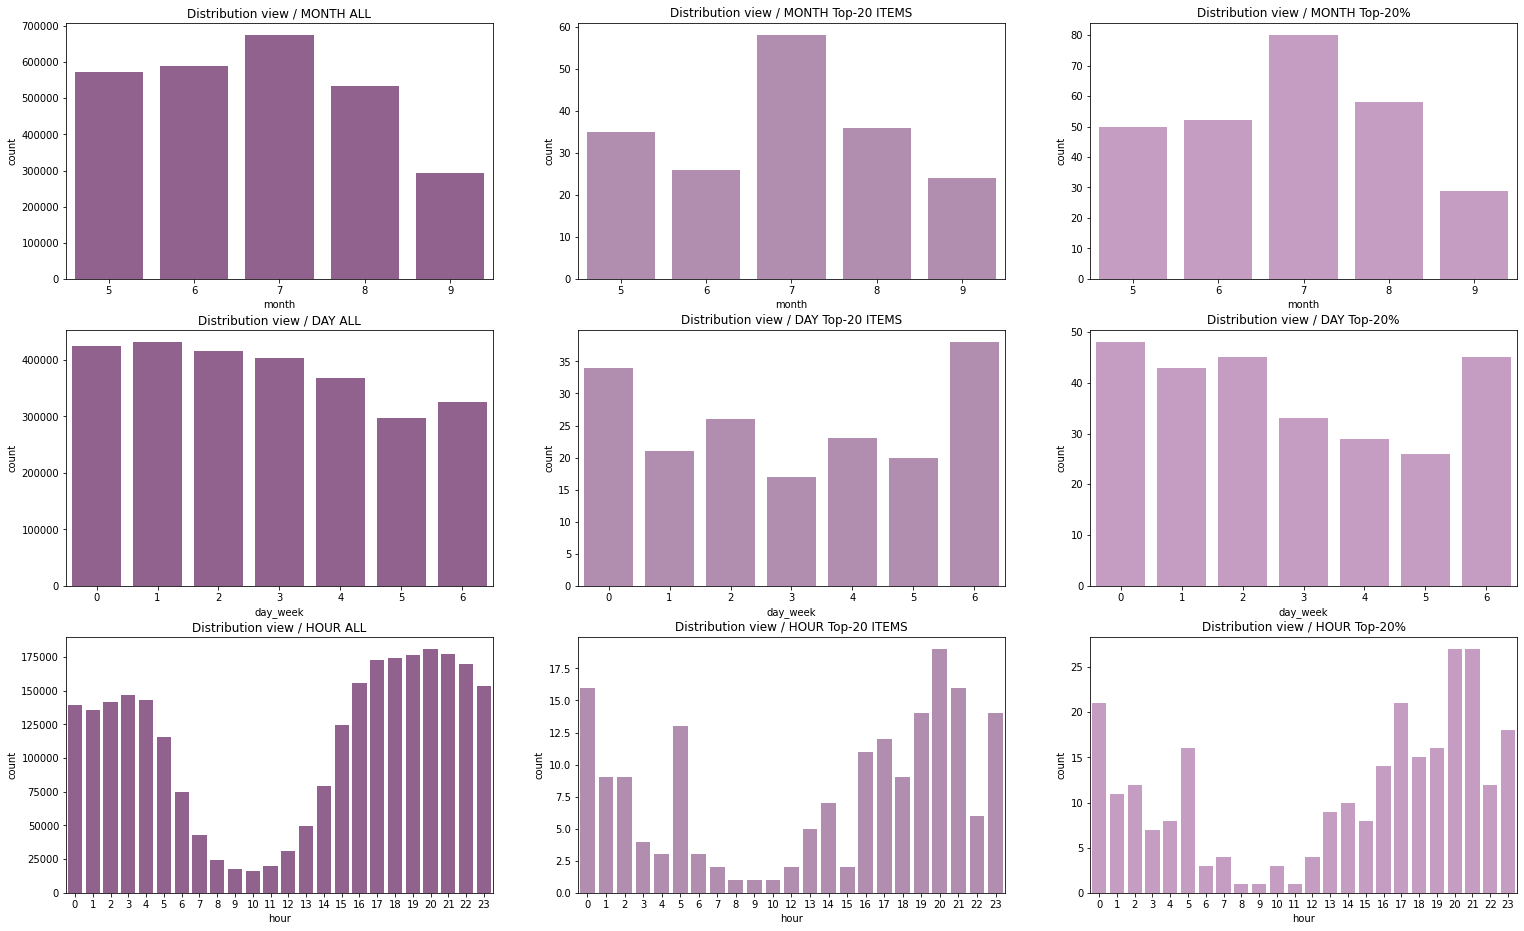

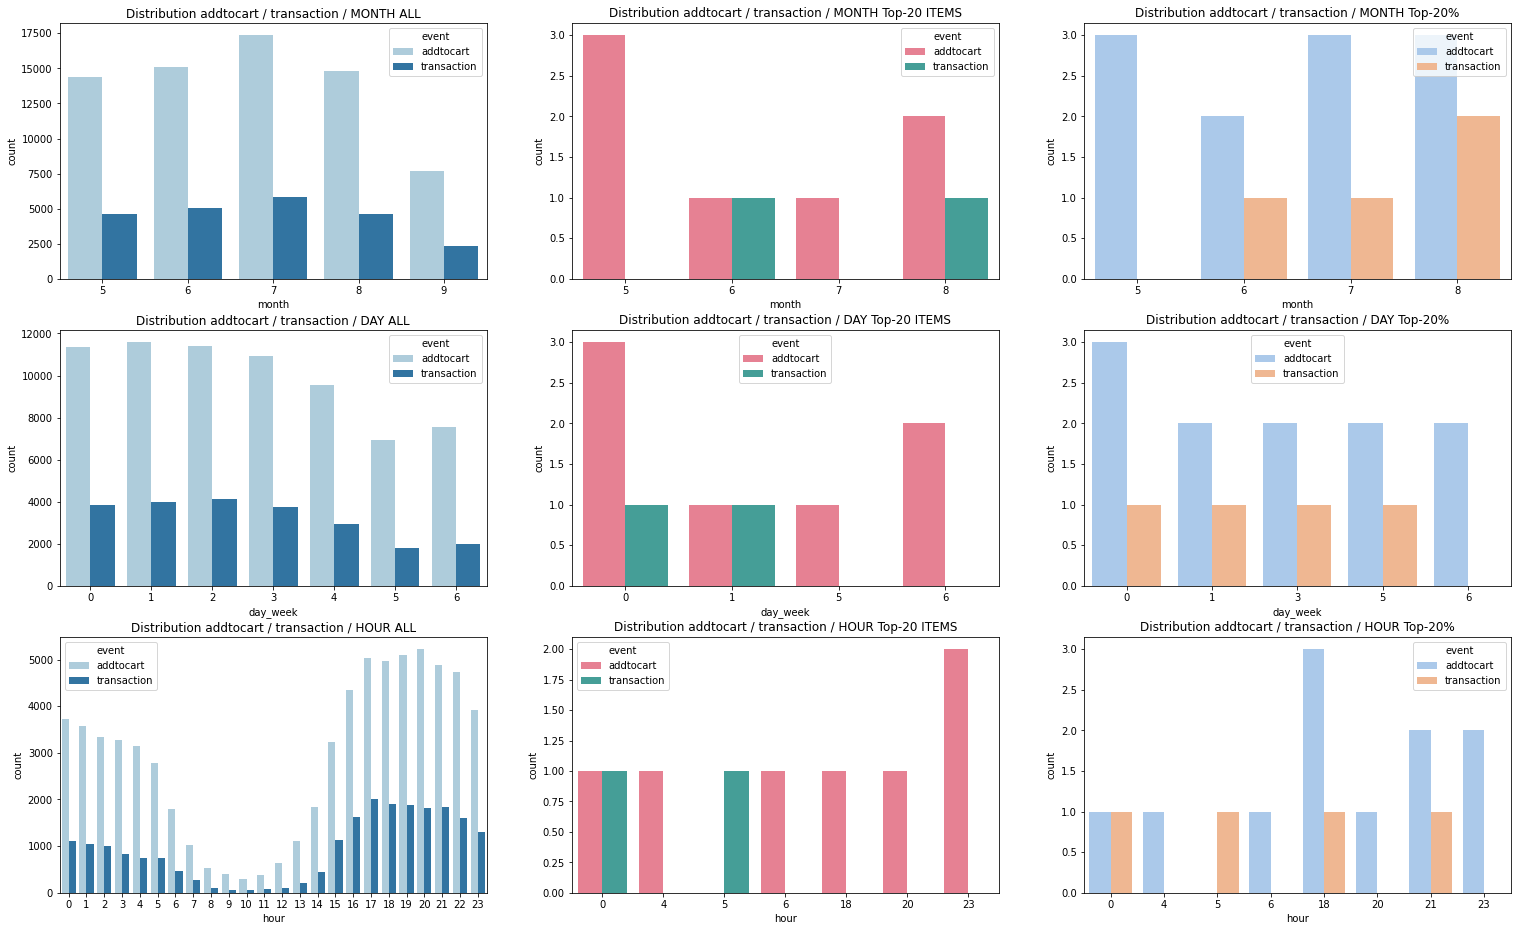

In [717]:
f1, axs = plt.subplots(3,3, figsize=(26, 16))

#View ALL
sns.barplot(ax=axs[0,0],
            x = 'month',
            y = 'count',
            data=month_ev_vis_all.loc[month_ev_vis_all.event=='view'],
            color ="#975b93").set(title="Distribution view / MONTH ALL")

sns.barplot(ax=axs[1,0],
            x = 'day_week',
            y = 'count',
            data=day_ev_vis_all.loc[day_ev_vis_all.event=='view'],
            color ="#975b93").set(title="Distribution view / DAY ALL")

sns.barplot(ax=axs[2,0],
            x = 'hour',
            y = 'count',
            data=hour_ev_vis_all.loc[hour_ev_vis_all.event=='view'],
            color ="#975b93").set(title="Distribution view / HOUR ALL")

#View Top-20
sns.barplot(ax=axs[0,1],
            x = 'month',
            y = 'count',
            data=month_ev_vis_20.loc[month_ev_vis_20.event=='view'],
            color ="#B787B4").set(title="Distribution view / MONTH Top-20 ITEMS")

sns.barplot(ax=axs[1,1],
            x = 'day_week',
            y = 'count',
            data=day_ev_vis_20.loc[day_ev_vis_20.event=='view'],
            color ="#B787B4").set(title="Distribution view / DAY Top-20 ITEMS")

sns.barplot(ax=axs[2,1],
            x = 'hour',
            y = 'count',
            data=hour_ev_vis_20.loc[hour_ev_vis_20.event=='view'],
            color ="#B787B4").set(title="Distribution view / HOUR Top-20 ITEMS")

#View Top-20%
sns.barplot(ax=axs[0,2],
            x = 'month',
            y = 'count',
            data=month_ev_vis_20per.loc[month_ev_vis_20per.event=='view'],
            color ="#cc96c9").set(title="Distribution view / MONTH Top-20%")

sns.barplot(ax=axs[1,2],
            x = 'day_week',
            y = 'count',
            data=day_ev_vis_20per.loc[day_ev_vis_20per.event=='view'],
            color ="#cc96c9").set(title="Distribution view / DAY Top-20%")

sns.barplot(ax=axs[2,2],
            x = 'hour',
            y = 'count',
            data=hour_ev_vis_20per.loc[hour_ev_vis_20per.event=='view'],
            color ="#cc96c9").set(title="Distribution view / HOUR Top-20%")
f1.show()

f2, axs = plt.subplots(3,3, figsize=(26, 16))

#Addtocart / transaction ALL
sns.barplot(ax=axs[0,0],
            x="month",
            y="count",
            hue='event',
            data=month_ev_vis_all.loc[month_ev_vis_all.event!='view'],
            palette='Paired').set(title="Distribution addtocart / transaction / MONTH ALL")

sns.barplot(ax=axs[1,0],
            x="day_week",
            y="count",
            hue='event',
            data=day_ev_vis_all.loc[day_ev_vis_all.event!='view'],
            palette="Paired").set(title="Distribution addtocart / transaction / DAY ALL")

sns.barplot(ax=axs[2,0],
            x="hour",
            y="count",
            hue='event',
            data=hour_ev_vis_all.loc[hour_ev_vis_all.event!='view'],
            palette="Paired").set(title="Distribution addtocart / transaction / HOUR ALL")

#Addtocart / transaction Top_20
sns.barplot(ax=axs[0,1],
            x="month",
            y="count",
            hue='event',
            data=month_ev_vis_20.loc[month_ev_vis_20.event!='view'],
            palette="husl").set(title="Distribution addtocart / transaction / MONTH Top-20 ITEMS")

sns.barplot(ax=axs[1,1],
            x="day_week",
            y="count",
            hue='event',
            data=day_ev_vis_20.loc[day_ev_vis_20.event!='view'],
            palette="husl").set(title="Distribution addtocart / transaction / DAY Top-20 ITEMS")

sns.barplot(ax=axs[2,1],
            x="hour",
            y="count",
            hue='event',
            data=hour_ev_vis_20.loc[hour_ev_vis_20.event!='view'],
            palette="husl").set(title="Distribution addtocart / transaction / HOUR Top-20 ITEMS")

#Addtocart / transaction Top_20%
sns.barplot(ax=axs[0,2],
            x="month",
            y="count",
            hue='event',
            data=month_ev_vis_20per.loc[month_ev_vis_20per.event!='view'],
            palette="pastel").set(title="Distribution addtocart / transaction / MONTH Top-20%")

sns.barplot(ax=axs[1,2],
            x="day_week",
            y="count",
            hue='event',
            data=day_ev_vis_20per.loc[day_ev_vis_20per.event!='view'],
            palette="pastel").set(title="Distribution addtocart / transaction / DAY Top-20%")

sns.barplot(ax=axs[2,2],
            x="hour",
            y="count",
            hue='event',
            data=hour_ev_vis_20per.loc[hour_ev_vis_20per.event!='view'],
            palette="pastel").set(title="Distribution addtocart / transaction / HOUR Top-20%")
f2.show()

Как мы уже установили ранее, количество просмотров значительно превышает добавления в корзину и собственно транзацкции, что также видно на визуализации. Пик всех активностей приходится на июль. По дням, на будние дни, в частности на понедельник, вторник, среду. По часам, активность высока вечером и ночью, достигает пика в 20:00 и значительно спадает после 5 утра.
Сильно выделяется топ-20 единичных уникальных товаров, по дням просмотра есть сиьный сдвиг на воскресенье и понедельник.Также стоит отметить, что в мае и сентябре они не продавались, хотя активно просматривались, продажи начались в июне и значительно возросли к августу. При этом их покупали только по понедельникам и вторникам, в 0:00 и в 05:00. А количество добавлений товаров в корзину сравнилось с количеством покупок. Скорее всего проводилась какая-то акция на данные товары, строго в определённое время, чтобы привлечь покупателей в период низкого трафика
Просмотры топ-20% товаров (20% с максимальным числом продаж) больше похожи на просмотры товаров всего датасета, однако другие действия по месяцам распределяются также, как топ-20 артикулов (нет продаж в мае и сентября, хотя просмотры есть). Добавления в корзину и покупки более равномерно распределяются по дням недели (хотя по средам и четвергам их нет), при распределении по часам часто количество добавлений в корзину также совпадает с количеством покупок, что также наводит на мысль о действии скидок в определенные часы.

Исходя из наблюдаемого, необходимо включить время активности пользователей относительно того или другого товара в число признаков.

# 6. Outliers handling

Поскольку общая задача проекта - предсказание артикулов, которые купит пользователь, для дальнейшей работы нам необходимо отобрать только тех пользователей, которые совершили покупки. Исходя из принципа деления на трейн и тест, по временному признаку, мы будем отбирать пользователей, которые совершили не менее 2 покупок. Также уберем возможные выбросы, чтобы избежать искажений при расчете модели.

In [718]:
#Selecting visitors with non less than 2 purchases
df_1 = events.copy()

cols = ['visitorid', 'event']
df_vis = df_1[cols]
df_vis = df_vis.loc[df_vis.event=='transaction']
df_vis['count'] = 1
df_vis.drop(columns='event', axis=1, inplace=True)
df_vis = df_vis.groupby('visitorid').sum().reset_index()
df_vis = df_vis.loc[df_vis['count']>1]
df_vis

,visitorid,count
0,172,2
2,264,2
12,2019,2
22,3104,2
26,3258,2
...,...,...
11683,1402220,3
11695,1403769,7
11701,1404265,2
11705,1404991,3


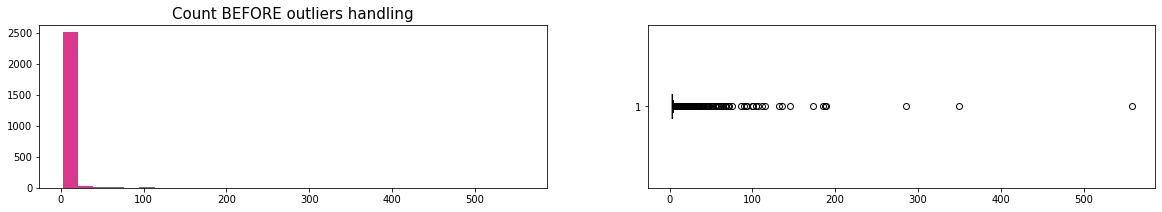

In [719]:
df = df_vis
feature = 'count'

fig, axs = plt.subplots(1, 2, figsize=(20, 3))
axs[0].hist(df[feature], bins=30, histtype='bar', orientation='vertical', color='#DB388D')
axs[0].set_title('Count BEFORE outliers handling', fontsize=15)
axs[1].boxplot(df[feature], vert=False)
fig.show()

In [720]:
#Statistic description
df_vis.describe()

,visitorid,count
count,2.576000e+03,2576.000000
mean,7.165735e+05,5.168478
std,4.012194e+05,18.517595
min,1.720000e+02,2.000000
25%,3.713838e+05,2.000000
50%,7.403535e+05,2.000000
75%,1.059046e+06,3.000000
max,1.406087e+06,559.000000


Среднее количество покупок, приходящихся на одного посетителя, не превышает 5 единиц. Поэтому мы можем оставить для дальнейшей работы только тех пользователей, кто совершил от 2 до 10 покупок (чтобы оставить количество пользователей достаточно вариативным).

Сразу можно сказать о том, что такое малое количество покупок на одного покупателя предсказывает нам сложности с коллаборативной фильтрацией по пользователям, потому что разброс будет велик. С другой стороны, возможно что в их покупках будут преобладать хиты продаж (топ-20), что может упростить процесс предсказания.

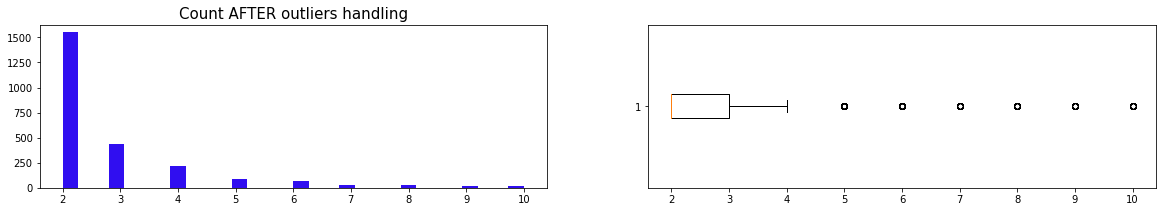

In [722]:
#Capping outliers
df_vis = df_vis.loc[(df_vis['count']==2)|(df_vis['count']<11)]
df = df_vis
feature = 'count'

fig, axs = plt.subplots(1, 2, figsize=(20, 3))
axs[0].hist(df[feature], bins=30, histtype='bar', orientation='vertical', color='#300ef0')
axs[0].set_title('Count AFTER outliers handling', fontsize=15)
axs[1].boxplot(df[feature], vert=False)
fig.show()

In [723]:
df_vis.describe()

,visitorid,count
count,2.438000e+03,2438.000000
mean,7.196018e+05,2.798195
std,4.015871e+05,1.467290
min,1.720000e+02,2.000000
25%,3.748370e+05,2.000000
50%,7.422210e+05,2.000000
75%,1.062136e+06,3.000000
max,1.406087e+06,10.000000


Как мы видим, большинство суммарных покупок пользователей за период наблюдений по-прежнему находятся в диапазоне от 2 до 4, однако их распределение стало более равномерным. При этом количество уникальных пользователей сократилось на 5%, поэтому можно сказать, что выборка остается достаточно репрезентативной.

In [724]:
df_vis_list = df_vis.visitorid.unique().tolist()
df_1=df_1.loc[df_1.visitorid.isin(df_vis_list)]

In [725]:
events = df_1.copy()
events

,timestamp,visitorid,event,itemid,transactionid,date,format_date,month,day_week,hour
27,1433222147345,1076270,view,262799,0.0,2015-06-02 05:15:47.345,2015-06-02,6,1,5
35,1433224644638,361387,view,43485,0.0,2015-06-02 05:57:24.638,2015-06-02,6,1,5
106,1433221123646,1076270,view,269430,0.0,2015-06-02 04:58:43.646,2015-06-02,6,1,4
196,1433193535886,820159,view,369447,0.0,2015-06-01 21:18:55.886,2015-06-01,6,0,21
211,1433194177067,1185234,view,154912,0.0,2015-06-01 21:29:37.067,2015-06-01,6,0,21
...,...,...,...,...,...,...,...,...,...,...
2755610,1438358117670,1188952,addtocart,194328,0.0,2015-07-31 15:55:17.670,2015-07-31,7,4,15
2755624,1438359207418,1015139,view,439726,0.0,2015-07-31 16:13:27.418,2015-07-31,7,4,16
2755626,1438360037777,572806,view,104781,0.0,2015-07-31 16:27:17.777,2015-07-31,7,4,16
2755769,1438406444601,115257,view,443791,0.0,2015-08-01 05:20:44.601,2015-08-01,8,5,5


# 7. Train & Test splitting
Мы выяснили, что покупки значительно зависят от временных признаков, поэтому сделаем так, чтобы данные по одному пользователю присутствовали в обеих частях. При этом более ранняя покупка пользователя уходит в трейн,а более поздняя - в тест. Далее мы скорретируем пропорции частей, чтобы они составляли 70/30.

In [726]:
df_3 = events.copy()
df_3['format_date'] = pd.to_datetime(df_3['timestamp'], unit='ms')

In [727]:
cols = ['visitorid', 'event', 'itemid', 'timestamp']
splitting = df_3[cols]

splitting = splitting.loc[splitting.event=='transaction']
splitting['date'] = pd.to_datetime(splitting['timestamp'], unit='ms')
splitting = splitting.sort_values(by=['visitorid','date'])
splitting.head()

,visitorid,event,itemid,timestamp,date
848114,172,transaction,465522,1439602141230,2015-08-15 01:29:01.230
850895,172,transaction,10034,1439602141686,2015-08-15 01:29:01.686
1276395,264,transaction,459835,1441647285614,2015-09-07 17:34:45.614
1283314,264,transaction,161949,1441647285708,2015-09-07 17:34:45.708
53617,2019,transaction,393144,1433368509996,2015-06-03 21:55:09.996


In [728]:
#Making an index for the next splitting
splitting['new_index'] = splitting.groupby('visitorid').cumcount().to_frame()
splitting = splitting.merge(df_vis, on='visitorid', how='left')
splitting.head()

#Cutting chunks according to purchases sum
chunk_2 = splitting.loc[splitting['count']==2]
chunk_3 = splitting.loc[splitting['count']==3]
chunk_4 = splitting.loc[splitting['count']==4]
chunk_5 = splitting.loc[splitting['count']==5]
chunk_big = splitting.loc[splitting['count']>5]

#Making Train & Test flags
chunk_2['flag'] = chunk_2['new_index'].apply(lambda x: 'train' if x<1 else 'test')
chunk_3['flag'] = chunk_3['new_index'].apply(lambda x: 'train' if x<2 else 'test')
chunk_4['flag'] = chunk_4['new_index'].apply(lambda x: 'train' if x<3 else 'test')
chunk_5['flag'] = chunk_5['new_index'].apply(lambda x: 'train' if x<4 else 'test')

#Combine the full frame
empty = pd.DataFrame()
big_visitors_list = chunk_big.visitorid.unique().tolist()

for vis in big_visitors_list:
    data = chunk_big.loc[chunk_big.visitorid==vis]
    margin = round(len(data)*0.7)-1
    data['flag'] = data['new_index'].apply(lambda x: 'train' if x<= margin else 'test')
    empty = pd.concat([empty, data])
    
splitting = pd.concat([chunk_2, chunk_3, chunk_3, chunk_4, chunk_5, empty])
splitting.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,visitorid,event,itemid,timestamp,date,new_index,count,flag
0,172,transaction,465522,1439602141230,2015-08-15 01:29:01.230,0,2,train
1,172,transaction,10034,1439602141686,2015-08-15 01:29:01.686,1,2,test
2,264,transaction,459835,1441647285614,2015-09-07 17:34:45.614,0,2,train
3,264,transaction,161949,1441647285708,2015-09-07 17:34:45.708,1,2,test
4,2019,transaction,393144,1433368509996,2015-06-03 21:55:09.996,0,2,train


In [729]:
splitting.head()

,visitorid,event,itemid,timestamp,date,new_index,count,flag
0,172,transaction,465522,1439602141230,2015-08-15 01:29:01.230,0,2,train
1,172,transaction,10034,1439602141686,2015-08-15 01:29:01.686,1,2,test
2,264,transaction,459835,1441647285614,2015-09-07 17:34:45.614,0,2,train
3,264,transaction,161949,1441647285708,2015-09-07 17:34:45.708,1,2,test
4,2019,transaction,393144,1433368509996,2015-06-03 21:55:09.996,0,2,train


In [730]:
#Train & Test shape comparison
train_labels = splitting.loc[splitting.flag=='train']
test_labels = splitting.loc[splitting.flag=='test']

print(train_labels.shape)
print(test_labels.shape)

(5062, 8)
(3065, 8)


In [731]:
#Ideal Train length:
train_len = round(len(splitting)*0.7)
print(train_len)

5689


Как мы видим, деление на Train & Test на текущий момент не сбалансировано (примерно 60/40). Деление на Train & Test было бы более пропорциональным, если бы длина Train достигала 5689 рядов. Выделим случайным способом недостающие ряды из Test и присоединим к Train.

In [732]:
add_len = train_len - len(train_labels)
add_labels = test_labels.sample(add_len)

#Final concatenation
train_labels = pd.concat([train_labels, add_labels])
train_labels['flag'] = 'train'

Фактически мы сейчас разделили на Train & Test только те события, которые относятся к транзакциям, то есть к покупкам. Однако для построения рекомендательной системы нам нужно будет в Train исследовать и остальные события, поскольку по ним мы сможем восстановить поведение покупателя. Поэтому сейчас мы выделим дату каждой последней покупки для каждого пользователя в Train по которой в дальнейшем будем проводить окончательную разбивку целого датасета.

In [733]:
#Making time labels for every user
user_time = train_labels.groupby('visitorid')

#Time label
label_date = user_time.max()['date'].to_frame().reset_index()
label_date = label_date.rename(columns={'date':'label_date_train'}) 

df_3 = df_3.merge(label_date, on='visitorid', how='left')

#Date difference
df_3['dif'] = df_3['format_date']-df_3['label_date_train']

#Вetermine the sign of the time delta
df_3['line'] = df_3['dif'].astype('str')
df_3['sign'] = df_3['line'].apply(lambda x: x[0])
df_3['label'] = df_3['sign'].apply(lambda x: 'train' if (x=='-' or x=='0') else 'drop')

df_3.head()

,timestamp,visitorid,event,itemid,transactionid,date,format_date,month,day_week,hour,label_date_train,dif,line,sign,label
0,1433222147345,1076270,view,262799,0.0,2015-06-02 05:15:47.345,2015-06-02 05:15:47.345,6,1,5,2015-06-02 05:36:30.388,-1 days +23:39:16.957000,-1 days +23:39:16.957000,-,train
1,1433224644638,361387,view,43485,0.0,2015-06-02 05:57:24.638,2015-06-02 05:57:24.638,6,1,5,2015-06-02 06:19:17.782,-1 days +23:38:06.856000,-1 days +23:38:06.856000,-,train
2,1433221123646,1076270,view,269430,0.0,2015-06-02 04:58:43.646,2015-06-02 04:58:43.646,6,1,4,2015-06-02 05:36:30.388,-1 days +23:22:13.258000,-1 days +23:22:13.258000,-,train
3,1433193535886,820159,view,369447,0.0,2015-06-01 21:18:55.886,2015-06-01 21:18:55.886,6,0,21,2015-06-01 21:31:56.927,-1 days +23:46:58.959000,-1 days +23:46:58.959000,-,train
4,1433194177067,1185234,view,154912,0.0,2015-06-01 21:29:37.067,2015-06-01 21:29:37.067,6,0,21,2015-05-15 23:06:20.829,16 days 22:23:16.238000,16 days 22:23:16.238000,1,drop


In [734]:
#Test
test = test_labels
cols = test.columns[:5]
test = test[cols]
test = test.drop_duplicates()

#Train
train = df_3.loc[df_3.label=='train']
col = train.columns[:7]
train = train[col]

display(train.head())
display(test.head())

,timestamp,visitorid,event,itemid,transactionid,date,format_date
0,1433222147345,1076270,view,262799,0.0,2015-06-02 05:15:47.345,2015-06-02 05:15:47.345
1,1433224644638,361387,view,43485,0.0,2015-06-02 05:57:24.638,2015-06-02 05:57:24.638
2,1433221123646,1076270,view,269430,0.0,2015-06-02 04:58:43.646,2015-06-02 04:58:43.646
3,1433193535886,820159,view,369447,0.0,2015-06-01 21:18:55.886,2015-06-01 21:18:55.886
5,1433193703544,820159,view,261793,0.0,2015-06-01 21:21:43.544,2015-06-01 21:21:43.544


,visitorid,event,itemid,timestamp,date
1,172,transaction,10034,1439602141686,2015-08-15 01:29:01.686
3,264,transaction,161949,1441647285708,2015-09-07 17:34:45.708
5,2019,transaction,445559,1433368510965,2015-06-03 21:55:10.965
7,3104,transaction,346661,1432273992770,2015-05-22 05:53:12.770
9,3258,transaction,19278,1434999874325,2015-06-22 19:04:34.325


# 8. Feature engineering

### Features Visitors

#### Time Features / Временные признаки

1.1. month / месяц

1.2. day_week / день недели

1.3. hour / час дня

#### Events Features / Признаки действий

2.1. add_visitor / суммарное количество добавлений в корзину у пользователя

2.2. trans_visitor / суммарное количество покупок у пользователя

2.3. view_visitor / суммарное количество просмотров у пользователя

2.4. all_events_vis / общее количество всех действий пользователя (сумма)

2.5. buy_% / доля покупок по отношению к общему количеству всех действий (% от всех действий) пользователя

2.6. view_trans_vis / среднее количество просмотров по отношению к покупке (сколько в среднем просмотров приходится на одну покупку) пользователя

2.7. add_trans_vis / среднее количество добавлений в корзину по отношению к покупке (сколько в среднем добавлений приходится на одну покупку) пользователя

2.8. view_purch_vis / количество просмотров при покупке данного айтема у пользователя (история покупок прослеживается по конкретному айтему)

2.9. add_purch_vis / количество добавлений в корзину при покупке данного айтема у пользователя (история покупок прослеживается по конкретному айтему)

#### Purchases Frequency Features / Признаки частотности покупок

3.1. items_per_trans / сколько айтемов было куплено в одном чеке (комплексность)

3.2. repeat_count / количество повторных покупок

#### Bestsellers Features / Признаки бестселлеров

4.1. top_20_purch / количество купленных пользователем товаров из списка ТОП-20 (20 наиболее часто продававшихся товаров)

4.2. month_top_purch /количество купленных пользователем товаров из списка бестселлеров месяца (10 наиболее часто продававшихся товаров, общий список уникальных артикулов для каждого месяца из периода наблюдений в датасете)

#### Activity Features / Признаки периодов наибольшей активности пользователя

5.1. activity_duration_vis / длительность периода активности (исчисляется в днях, от первого до последнего дня активности в системе)

5.2. month_vis / месяц совершения наибольшего числа покупок

5.3. day_vis / день недели, в который пользователь совершает наибольшее количество покупок

5.4. hour_vis / час дня, в который пользователь совершает наибольшее количество покупок

5.5. activity_vis_days / количество дней, в которые покупатель совершил покупку (например, покупатель был активен 5 дней, но покупал только 2 дня из них, 2 дня относятся к этому признаку)

5.6. usedays% / доля результативных дней, в которые совершались покупки, по отношению ко всему периоду активности (например, покупатель был активен 5 дней, но покупал только 2 дня из них, 2/5*100% - 40% были результативными для системы)

In [735]:
user_features = train.copy()

In [736]:
user_features['month'] = pd.DatetimeIndex(user_features['format_date']).month
user_features['day_week'] = pd.DatetimeIndex(user_features['format_date']).dayofweek
user_features['hour'] = pd.DatetimeIndex(user_features['format_date']).hour

In [737]:
#Pivoting
cols = ['visitorid', 'event']
user_events = train[cols]
user_events['count'] = 1

user_events = pd.pivot_table(user_events,
                            values='count', 
                            index=['visitorid'],
                            columns=['event'], aggfunc=np.sum, fill_value=0)
#Adding features
user_events = user_events.reset_index()
user_events['all_events_vis'] = user_events['addtocart']+user_events['transaction']+user_events['view']
user_events['buy_%'] = round((user_events['transaction']/user_events['all_events_vis']*100))

user_events = user_events.rename(columns={'addtocart': 'add_visitor',
                                        'transaction': 'trans_visitor',
                                        'view': 'view_visitor'})


user_events['view_trans_vis'] = round((user_events['view_visitor']/user_events['trans_visitor']),2)
user_events['add_trans_vis'] = round((user_events['add_visitor']/user_events['trans_visitor']),2)

#Adding to frame
user_features = user_features.merge(user_events, on='visitorid', how='left')

#Purchases statistic
cols = ['visitorid', 'itemid', 'event']
user_purchases = train[cols]
purch_items = user_purchases.loc[user_purchases.event=='transaction']['itemid'].tolist()
user_purchases = user_purchases.loc[user_purchases.itemid.isin(purch_items)]  
user_purchases['count'] = 1

#Pivoting
user_purchases = pd.pivot_table(user_purchases,
                            values='count', 
                            index=['visitorid'],
                            columns=['event'], aggfunc=np.sum, fill_value=0)


user_purchases['view_purch_vis'] = round((user_purchases['view']/user_purchases['transaction']),2)
user_purchases['add_purch_vis'] = round((user_purchases['addtocart']/user_purchases['transaction']),2)

cols = ['view_purch_vis', 'add_purch_vis']
user_purchases = user_purchases[cols].reset_index()

#Adding to frame
user_features = user_features.merge(user_purchases, on='visitorid', how='left')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [738]:
#Items per Transaction
cols = ['visitorid', 'transactionid']

prod_features_df = train.loc[train.event=='transaction'][cols]
prod_features_df['items_per_trans'] = 1

#Pivoting
prod_features_df = prod_features_df.groupby(by=['visitorid', 'transactionid']).sum()

prod_features_df = prod_features_df.groupby(by=['visitorid']).mean()
prod_features_df['items_per_trans'] = round(prod_features_df['items_per_trans'],2)
prod_features_df = prod_features_df.reset_index()

#Adding to frame
user_features = user_features.merge(prod_features_df, on='visitorid', how='left')

#Repeat purchasing
cols = ['visitorid', 'itemid']
repeat_purch = user_features.loc[user_features.event=='transaction'][cols]
repeat_purch['items_count'] = 1
repeat_purch = repeat_purch.groupby(['visitorid', 'itemid']).sum()
repeat_purch = repeat_purch.loc[repeat_purch['items_count']>1]
repeat_purch['repeat_count'] = 1
repeat_purch = repeat_purch.groupby(by='visitorid').sum().reset_index()
repeat_purch = repeat_purch[['visitorid', 'repeat_count']]

#Adding to frame
user_features = user_features.merge(repeat_purch, on='visitorid', how='left')

In [739]:
#Top_20 (frequency)
### Top_20 Products
top_20_items = train.loc[train.event=='transaction']['itemid'].value_counts()[:20].index.tolist()

cols = ['visitorid', 'itemid']
bestsellers_purchase = user_features.loc[user_features.event=='transaction'][cols]
bestsellers_purchase = bestsellers_purchase.loc[bestsellers_purchase.itemid.isin(top_20_items)]
bestsellers_purchase['top_20_purch'] = 1
bestsellers_purchase = bestsellers_purchase.groupby(by='visitorid').sum().reset_index()
bestsellers_purchase = bestsellers_purchase[['visitorid', 'top_20_purch']]

#Adding to frame
user_features = user_features.merge(bestsellers_purchase, on='visitorid', how='left')

#Monthly_top (10 items frequency)
#Selecting the most popular items for every month
month_list = user_features.month.unique().tolist()

top_10_5 = user_features.loc[(user_features.event=='transaction')&(user_features.month==5)]['itemid'].value_counts()[:10].index.tolist()
top_10_6 = user_features.loc[(user_features.event=='transaction')&(user_features.month==6)]['itemid'].value_counts()[:10].index.tolist()
top_10_7 = user_features.loc[(user_features.event=='transaction')&(user_features.month==7)]['itemid'].value_counts()[:10].index.tolist()
top_10_8 = user_features.loc[(user_features.event=='transaction')&(user_features.month==8)]['itemid'].value_counts()[:10].index.tolist()
top_10_9 = user_features.loc[(user_features.event=='transaction')&(user_features.month==8)]['itemid'].value_counts()[:10].index.tolist()

full_month_top = list(set(top_10_5+top_10_6+top_10_7+top_10_8+top_10_9))

cols = ['visitorid', 'itemid']
month_top_purchase = user_features.loc[user_features.event=='transaction'][cols]
month_top_purchase = month_top_purchase.loc[month_top_purchase.itemid.isin(full_month_top)]
month_top_purchase['month_top_purch'] = 1
month_top_purchase = month_top_purchase.groupby(by='visitorid').sum().reset_index()
month_top_purchase = month_top_purchase[['visitorid', 'month_top_purch']]

#Adding to frame
user_features = user_features.merge(month_top_purchase, on='visitorid', how='left')

In [740]:
#Activity duration
cols = ['visitorid', 'format_date', 'month', 'day_week', 'hour']
user_time = user_features[cols]

user_time = user_time.groupby('visitorid')

#Avtivity period
first_date = user_time.min().format_date.to_frame().reset_index()
first_date = first_date.rename(columns={'format_date':'first_date_vis'})
last_date = user_time.max().format_date.to_frame().reset_index()
last_date = last_date.rename(columns={'format_date':'last_date_vis'}) 

#Adding to data
user_features = user_features.merge(first_date, how='left', on='visitorid')
user_features = user_features.merge(last_date, how='left', on='visitorid')

#Counting time delta
user_features['activity_duration_vis'] = user_features['last_date_vis'] - user_features['first_date_vis']

#Preferred months, days and hours
#Purchases filtration (event == 'transaction')
cols = ['visitorid', 'event', 'format_date', 'month', 'day_week', 'hour']
user_time = user_features[cols]
user_time = user_time.loc[user_time.event=='transaction']
user_time = user_time.groupby('visitorid')

month_pref = user_time.month.agg(lambda x: scipy.stats.mode(x)[0]).reset_index()
month_pref = month_pref.rename(columns={'month':'month_vis'})

day_pref = user_time.day_week.agg(lambda x: scipy.stats.mode(x)[0]).reset_index()
day_pref = day_pref.rename(columns={'day_week':'day_vis'})

hour_pref = user_time.hour.agg(lambda x: scipy.stats.mode(x)[0]).reset_index()
hour_pref = hour_pref.rename(columns={'hour':'hour_vis'})

#Adding to data
user_features = user_features.merge(month_pref, how='left', on='visitorid')
user_features = user_features.merge(day_pref, how='left', on='visitorid')
user_features = user_features.merge(hour_pref, how='left', on='visitorid')

user_features['activity_vis_days'] = user_features['activity_duration_vis'].dt.days

#We count as activity even only one day with the same date (where timedelta is 0)
user_features['activity_vis_days'] = user_features['activity_vis_days']+1

#Number of active days
cols = ['visitorid', 'format_date']
active_days = user_features[cols]
active_days['date'] = active_days['format_date'].dt.date
active_days = active_days.groupby(by=['visitorid', 'date']).sum()
active_days['use_days'] = 1
active_days = active_days.groupby(by='visitorid').sum().reset_index()

#Adding to data
user_features = user_features.merge(active_days, how='left', on='visitorid')

#Activity days proportion
user_features['use_days_%'] = round((user_features['use_days']/user_features['activity_vis_days']),2)

user_features['correction'] = user_features['use_days_%'].apply(lambda x: x if x!=2 else 1)
user_features.drop(columns=['use_days_%'], axis=1, inplace=True)
user_features = user_features.rename(columns={'correction': 'use_days_%'})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.


In [741]:
user_features

,timestamp,visitorid,event,itemid,transactionid,date,format_date,month,day_week,hour,...,month_top_purch,first_date_vis,last_date_vis,activity_duration_vis,month_vis,day_vis,hour_vis,activity_vis_days,use_days,use_days_%
0,1433222147345,1076270,view,262799,0.0,2015-06-02 05:15:47.345,2015-06-02 05:15:47.345,6,1,5,...,NaN,2015-06-02 04:58:43.646,2015-06-02 05:36:30.388,0 days 00:37:46.742000,6,1,5,1,1,1.00
1,1433224644638,361387,view,43485,0.0,2015-06-02 05:57:24.638,2015-06-02 05:57:24.638,6,1,5,...,NaN,2015-06-02 05:47:48.625,2015-06-03 00:51:57.627,0 days 19:04:09.002000,6,1,6,1,2,1.00
2,1433221123646,1076270,view,269430,0.0,2015-06-02 04:58:43.646,2015-06-02 04:58:43.646,6,1,4,...,NaN,2015-06-02 04:58:43.646,2015-06-02 05:36:30.388,0 days 00:37:46.742000,6,1,5,1,1,1.00
3,1433193535886,820159,view,369447,0.0,2015-06-01 21:18:55.886,2015-06-01 21:18:55.886,6,0,21,...,NaN,2015-06-01 15:06:11.829,2015-06-01 23:53:08.608,0 days 08:46:56.779000,6,0,17,1,1,1.00
4,1433193703544,820159,view,261793,0.0,2015-06-01 21:21:43.544,2015-06-01 21:21:43.544,6,0,21,...,NaN,2015-06-01 15:06:11.829,2015-06-01 23:53:08.608,0 days 08:46:56.779000,6,0,17,1,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57206,1438357544346,1188952,addtocart,430566,0.0,2015-07-31 15:45:44.346,2015-07-31 15:45:44.346,7,4,15,...,NaN,2015-05-25 19:19:55.766,2015-08-26 22:12:46.035,93 days 02:52:50.269000,8,2,17,94,15,0.16
57207,1438358117670,1188952,addtocart,194328,0.0,2015-07-31 15:55:17.670,2015-07-31 15:55:17.670,7,4,15,...,NaN,2015-05-25 19:19:55.766,2015-08-26 22:12:46.035,93 days 02:52:50.269000,8,2,17,94,15,0.16
57208,1438360037777,572806,view,104781,0.0,2015-07-31 16:27:17.777,2015-07-31 16:27:17.777,7,4,16,...,NaN,2015-07-14 21:47:35.506,2015-08-18 21:43:10.814,34 days 23:55:35.308000,7,1,18,35,5,0.14
57209,1438406444601,115257,view,443791,0.0,2015-08-01 05:20:44.601,2015-08-01 05:20:44.601,8,5,5,...,NaN,2015-07-24 13:53:20.746,2015-08-08 05:02:02.153,14 days 15:08:41.407000,8,4,7,15,8,0.53


In [742]:
#Features
feat_list = ['buy_%',
             'view_trans_vis',
             'add_trans_vis',
             'view_purch_vis',
             'add_purch_vis',
             'items_per_trans',
             'repeat_count',
             'top_20_purch',
             'month_top_purch',
             'month_vis',
             'day_vis',
             'hour_vis',
             'activity_vis_days',
             'use_days',
             'use_days_%']

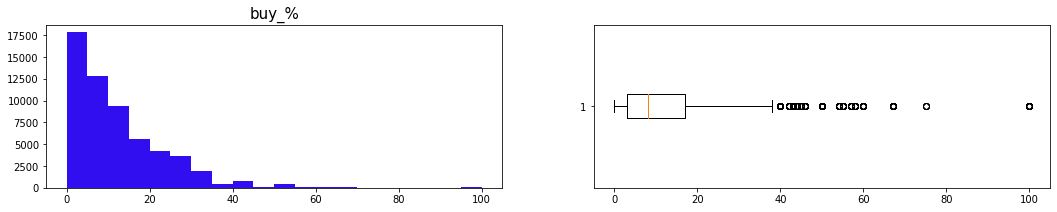

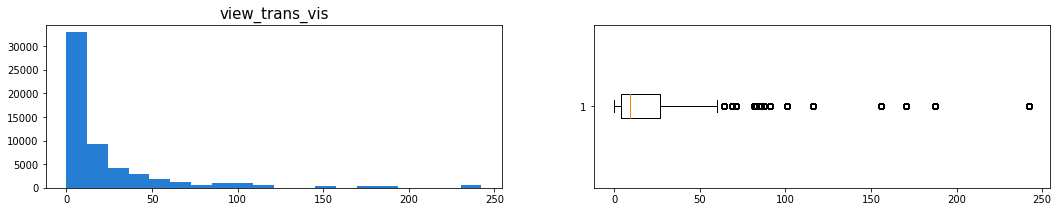

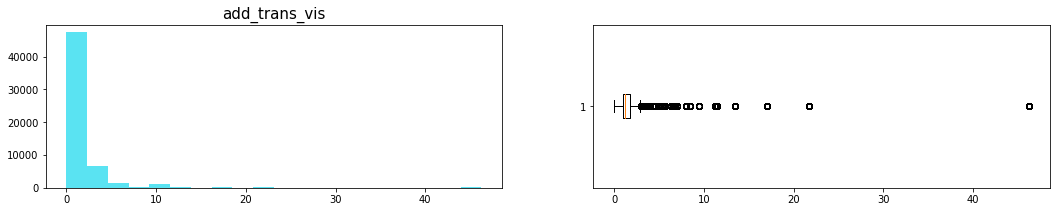

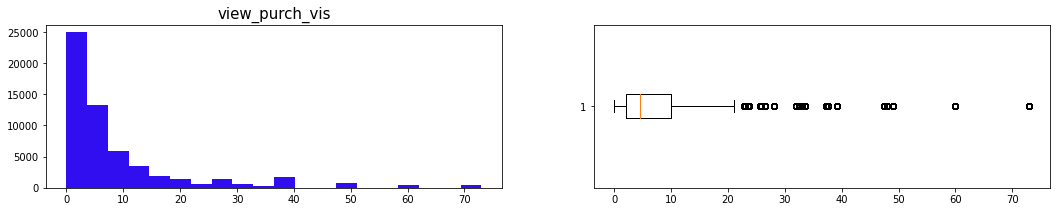

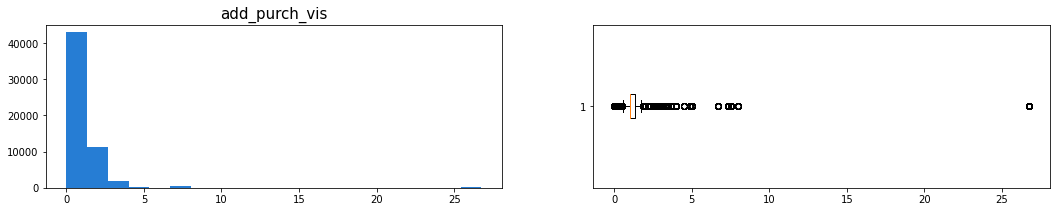

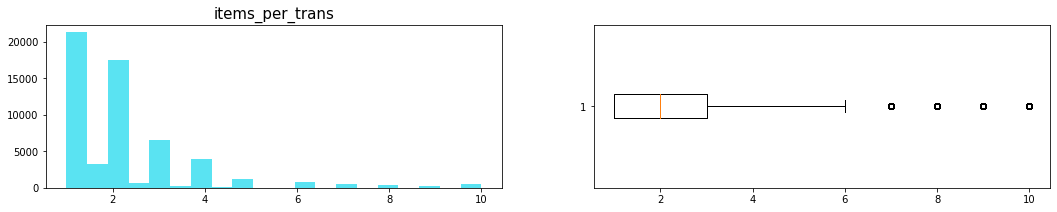

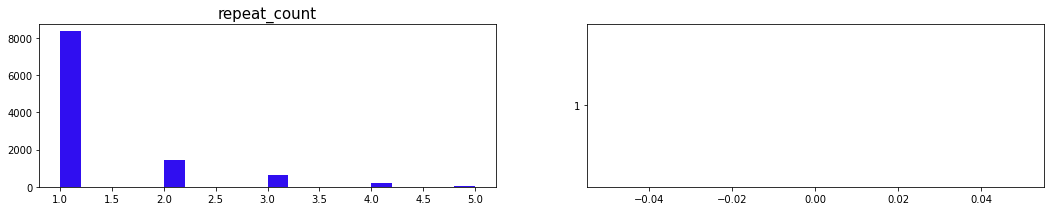

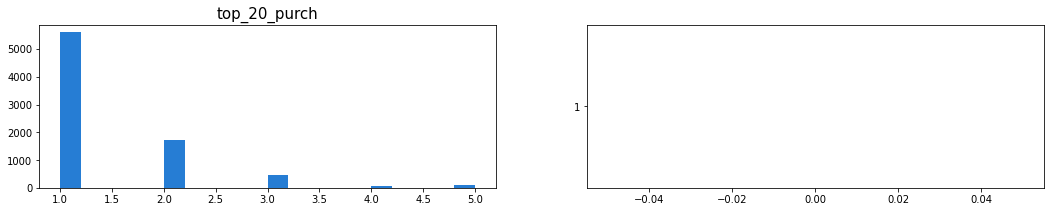

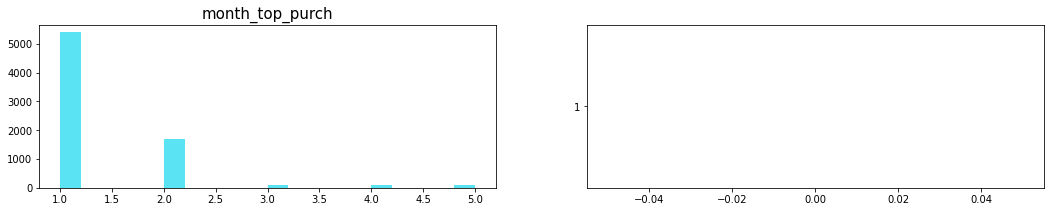

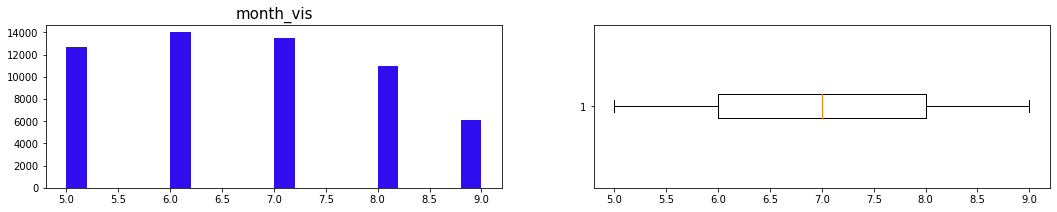

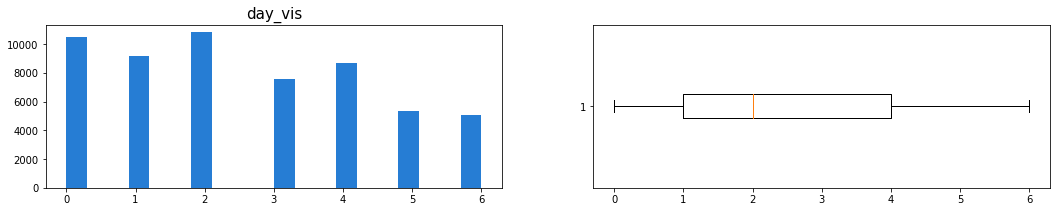

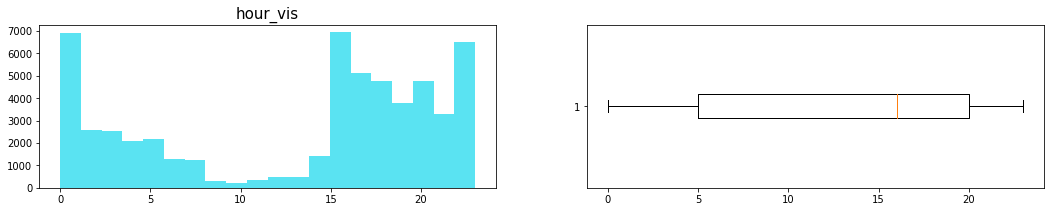

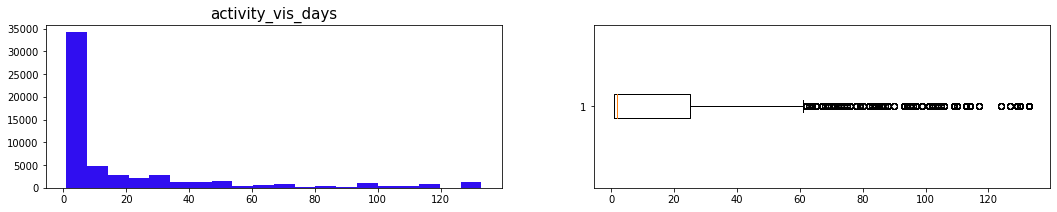

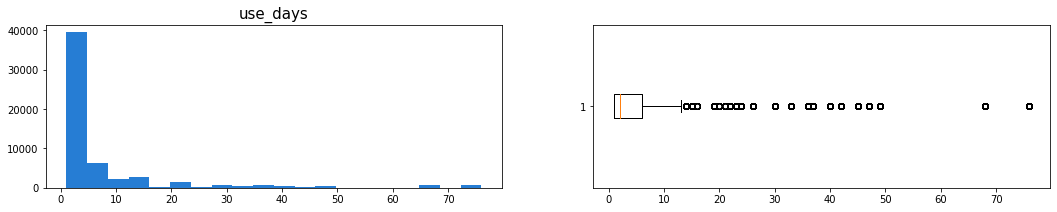

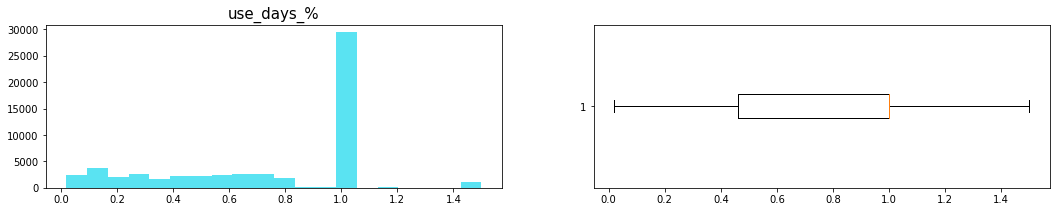

In [745]:
#Visualization
#Colors
clr_list = ['#300ef0', '#267dd4', '#5ae3f2']
    
df_list = [user_features]
for df,feat,clr in zip(cycle(df_list), feat_list, cycle(clr_list)):
    feature_distribution(df, feat, clr)

Судя по большому количеству близких к единичным покупок (от 2), малому количеству повторяющихся покупок, сравнительно малому времени, которое пользователи уделяют просмотру товаров перед покупкой, а также большой доле дней, во время которых совершалась покупка и эта же покупка была единственной во всем периоде активности (use_days_% = 1), существенная доля всех пользователей приходила в систему для того, чтобы купить заранее намеченные хиты. Похожую картину мы видели выше, когда проводили полный обзор датасета до разделения на Train & Test. Иными словами, общий тренд - единичные покупки хитов.

### ITEM features

#### 1. Time Features / Временные признаки
1.1. month / месяц

1.2. day_week / день недели

1.3. hour / час дня

#### 2. Events Features / Признаки действий
2.1. add_item / суммарное количество добавлений артикула (товара) в корзину

2.2. trans_item / суммарное количество покупок артикула

2.3. view_item / суммарное количество просмотров артикула

2.4. all_events_itm / общее количество всех действий по отношению к артикулу (сумма)

2.5. sale_% / доля продаж по отношению к общему количеству всех действий с товаром

#### 3. Sales Frequency Features / Признаки частотности продаж
3.1. repeat_count / количество повторных покупок артикула

#### 4. Bestsellers Features / Признаки бестселлеров
4.1. top_20_sale / входит ли артикул в ТОП-20 (20 наиболее часто продававшихся товаров)

4.2. top_month_sale /входит ли артикул в общий список бестселлеров месяца (10 наиболее часто продававшихся товаров, общий список уникальных артикулов для каждого месяца из периода наблюдений в датасете)

#### 5. Activity Features / Признаки периодов наиболее активного взаимодействия пользователя с товарами
5.1. activity_duration_itm / длительность периода активности (исчисляется в днях, от первого до последнего дня взаимодействия пользователя с товаром в системе)

5.2. month_itm / месяц наиболее частых продаж артикула

5.3. day_itm / день недели, в который артикул чаще всего продавался

5.4. hour_itm / час дня, в который артикул чаще всего продавался

5.5. sale_days / количество дней, в которые совершалась продажа артикула

5.6. sale_day_s% / доля результативных дней, в которые совершались продажи артикула, по отношению ко всему периоду активности (например, покупатели просматривали артикул в течение 5 дней, но покупали только 2 дня из них, 2/5*100% - 40% были результативными для системы)

In [746]:
item_features = train.copy()
item_features['month'] = pd.DatetimeIndex(item_features['format_date']).month
item_features['day_week'] = pd.DatetimeIndex(item_features['format_date']).dayofweek
item_features['hour'] = pd.DatetimeIndex(item_features['format_date']).hour

In [747]:
#Pivoting
cols = ['itemid', 'event']
item_events = train[cols]
item_events['count'] = 1

item_events = pd.pivot_table(item_events,
                            values='count', 
                            index=['itemid'],
                            columns=['event'], aggfunc=np.sum, fill_value=0)
#Adding features
item_events = item_events.reset_index()
item_events['all_events_itm'] = item_events['addtocart']+item_events['transaction']+item_events['view']
item_events['sale_%'] = round((item_events['transaction']/item_events['all_events_itm']*100))

item_events = item_events.rename(columns={'addtocart': 'add_item',
                                        'transaction': 'trans_item',
                                        'view': 'view_item'})

#Adding to frame
item_features = item_features.merge(item_events, on='itemid', how='left')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [748]:
#Repeat sale
cols = ['visitorid', 'itemid']
repeat_sale = item_features.loc[user_features.event=='transaction'][cols]
repeat_sale['items_count'] = 1
repeat_sale = repeat_sale.groupby(['itemid', 'visitorid']).sum()
repeat_sale = repeat_sale.loc[repeat_sale['items_count']>1]
repeat_sale['repeat_count'] = 1
repeat_sale = repeat_sale.groupby(by='itemid').sum().reset_index()
repeat_sale = repeat_sale[['itemid', 'repeat_count']]

#Adding to frame
item_features = item_features.merge(repeat_sale, on='itemid', how='left')

In [749]:
#Top_20 (frequency)
### Top_20 Products
top_20_items = train.loc[train.event=='transaction']['itemid'].value_counts()[:20].index.tolist()
### Make a flag for top-20 products
cols = ['visitorid', 'itemid']
bestsellers_20 = item_features[cols].drop_duplicates().reset_index(drop=True)
bestsellers_20 = bestsellers_20.loc[bestsellers_20.itemid.isin(top_20_items)]
bestsellers_20['top_20_sale'] = 1

bestsellers_20.drop('visitorid', axis=1,inplace=True)
bestsellers_20 = bestsellers_20.drop_duplicates()

#Adding to the frame
item_features = item_features.merge(bestsellers_20, on='itemid', how='left')

#Monthly_top (10 items frequency)
cols = ['visitorid', 'itemid']
month_bestsellers = item_features[cols].drop_duplicates().reset_index(drop=True)
month_bestsellers = month_bestsellers.loc[month_bestsellers.itemid.isin(full_month_top)]
month_bestsellers['top_month_sale'] = 1

month_bestsellers.drop('visitorid', axis=1,inplace=True)
month_bestsellers = month_bestsellers.drop_duplicates()

#Adding to the frame
item_features = item_features.merge(month_bestsellers, on='itemid', how='left')

In [750]:
#Activity duration
cols = ['itemid', 'format_date', 'month', 'day_week', 'hour']
item_time = item_features[cols]

item_time = item_time.groupby('itemid')

#Avtivity period
first_date = item_time.min().format_date.to_frame().reset_index()
first_date = first_date.rename(columns={'format_date':'first_date_itm'})
last_date = item_time.max().format_date.to_frame().reset_index()
last_date = last_date.rename(columns={'format_date':'last_date_itm'}) 

#Adding to data
item_features = item_features.merge(first_date, how='left', on='itemid')
item_features = item_features.merge(last_date, how='left', on='itemid')

#Counting time delta
item_features['activity_duration_itm'] = item_features['last_date_itm'] - item_features['first_date_itm']

###Preferred months, days and hours
#Sales filtration (event == 'transaction')
cols = ['itemid', 'event', 'format_date', 'month', 'day_week', 'hour']
item_time = item_features[cols]
item_time = item_time.loc[item_time.event=='transaction']
item_time = item_time.groupby('itemid')

month_pref = item_time.month.agg(lambda x: scipy.stats.mode(x)[0]).reset_index()
month_pref = month_pref.rename(columns={'month':'month_itm'})

day_pref = item_time.day_week.agg(lambda x: scipy.stats.mode(x)[0]).reset_index()
day_pref = day_pref.rename(columns={'day_week':'day_itm'})

hour_pref = item_time.hour.agg(lambda x: scipy.stats.mode(x)[0]).reset_index()
hour_pref = hour_pref.rename(columns={'hour':'hour_itm'})

#Adding to data
item_features = item_features.merge(month_pref, how='left', on='itemid')
item_features = item_features.merge(day_pref, how='left', on='itemid')
item_features = item_features.merge(hour_pref, how='left', on='itemid')

item_features['activity_itm_days'] = item_features['activity_duration_itm'].dt.days

#We count as activity even only one day with the same date (where timedelta is 0)
item_features['activity_itm_days'] = item_features['activity_itm_days']+1

#Number of active sale days
cols = ['itemid', 'format_date']
active_days = item_features[cols]
active_days['date'] = active_days['format_date'].dt.date
active_days = active_days.groupby(by=['itemid', 'date']).sum()
active_days['sale_days'] = 1
active_days = active_days.groupby(by='itemid').sum().reset_index()

#Adding to data
item_features = item_features.merge(active_days, how='left', on='itemid')

#Activity days proportion
item_features['sale_days_%'] = round((item_features['sale_days']/item_features['activity_itm_days']),2)

item_features['correction'] = item_features['sale_days_%'].apply(lambda x: x if x!=2 else 1)
item_features.drop(columns=['sale_days_%'], axis=1, inplace=True)
item_features = item_features.rename(columns={'correction': 'sale_days_%'})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.


In [751]:
item_features

,timestamp,visitorid,event,itemid,transactionid,date,format_date,month,day_week,hour,...,top_month_sale,first_date_itm,last_date_itm,activity_duration_itm,month_itm,day_itm,hour_itm,activity_itm_days,sale_days,sale_days_%
0,1433222147345,1076270,view,262799,0.0,2015-06-02 05:15:47.345,2015-06-02 05:15:47.345,6,1,5,...,NaN,2015-06-02 05:11:59.130,2015-06-16 21:59:51.669,14 days 16:47:52.539000,6.0,1.0,5.0,15,2,0.13
1,1433224644638,361387,view,43485,0.0,2015-06-02 05:57:24.638,2015-06-02 05:57:24.638,6,1,5,...,NaN,2015-05-12 17:46:40.353,2015-06-03 00:51:57.627,21 days 07:05:17.274000,6.0,1.0,6.0,22,3,0.14
2,1433221123646,1076270,view,269430,0.0,2015-06-02 04:58:43.646,2015-06-02 04:58:43.646,6,1,4,...,NaN,2015-06-01 00:19:28.670,2015-06-02 05:20:49.099,1 days 05:01:20.429000,NaN,NaN,NaN,2,2,1.00
3,1433193535886,820159,view,369447,0.0,2015-06-01 21:18:55.886,2015-06-01 21:18:55.886,6,0,21,...,1.0,2015-05-04 04:02:56.466,2015-07-03 20:18:05.373,60 days 16:15:08.907000,5.0,0.0,20.0,61,14,0.23
4,1433193703544,820159,view,261793,0.0,2015-06-01 21:21:43.544,2015-06-01 21:21:43.544,6,0,21,...,NaN,2015-06-01 21:21:43.544,2015-06-01 21:21:43.544,0 days 00:00:00,NaN,NaN,NaN,1,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57206,1438357544346,1188952,addtocart,430566,0.0,2015-07-31 15:45:44.346,2015-07-31 15:45:44.346,7,4,15,...,NaN,2015-07-31 15:45:28.920,2015-07-31 15:45:44.346,0 days 00:00:15.426000,NaN,NaN,NaN,1,1,1.00
57207,1438358117670,1188952,addtocart,194328,0.0,2015-07-31 15:55:17.670,2015-07-31 15:55:17.670,7,4,15,...,NaN,2015-07-30 15:24:27.430,2015-07-31 15:55:30.135,1 days 00:31:02.705000,NaN,NaN,NaN,2,2,1.00
57208,1438360037777,572806,view,104781,0.0,2015-07-31 16:27:17.777,2015-07-31 16:27:17.777,7,4,16,...,NaN,2015-07-09 16:14:53.790,2015-07-31 16:27:17.777,22 days 00:12:23.987000,7.0,3.0,16.0,23,4,0.17
57209,1438406444601,115257,view,443791,0.0,2015-08-01 05:20:44.601,2015-08-01 05:20:44.601,8,5,5,...,NaN,2015-08-01 05:20:44.601,2015-08-01 05:20:44.601,0 days 00:00:00,NaN,NaN,NaN,1,1,1.00


In [752]:
item_feat_list = ['add_item',
                  'trans_item',
                  'view_item',
                  'all_events_itm',
                  'sale_%',
                  'repeat_count',
                  'month_itm',
                  'day_itm',
                  'hour_itm',
                  'activity_itm_days',
                  'sale_days',
                  'sale_days_%']

In [753]:
item_features[item_feat_list].fillna(0)

,add_item,trans_item,view_item,all_events_itm,sale_%,repeat_count,month_itm,day_itm,hour_itm,activity_itm_days,sale_days,sale_days_%
0,1,1,5,7,14.0,0.0,6.0,1.0,5.0,15,2,0.13
1,0,2,11,13,15.0,1.0,6.0,1.0,6.0,22,3,0.14
2,1,0,5,6,0.0,0.0,0.0,0.0,0.0,2,2,1.00
3,5,5,34,44,11.0,0.0,5.0,0.0,20.0,61,14,0.23
4,0,0,1,1,0.0,0.0,0.0,0.0,0.0,1,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
57206,2,0,0,2,0.0,0.0,0.0,0.0,0.0,1,1,1.00
57207,2,0,2,4,0.0,0.0,0.0,0.0,0.0,2,2,1.00
57208,3,1,7,11,9.0,0.0,7.0,3.0,16.0,23,4,0.17
57209,0,0,1,1,0.0,0.0,0.0,0.0,0.0,1,1,1.00


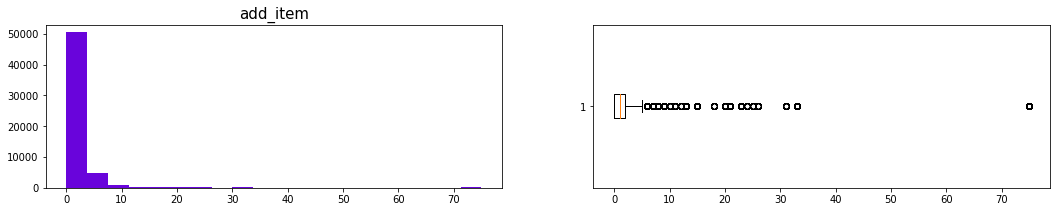

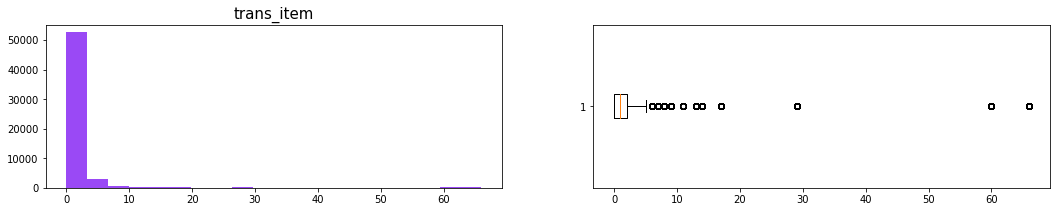

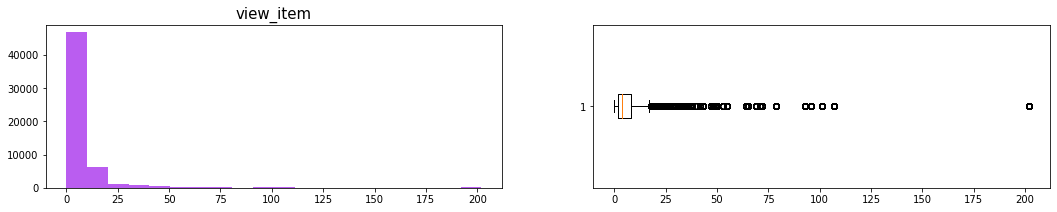

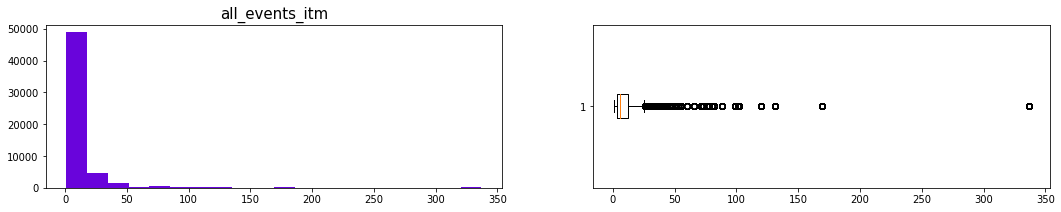

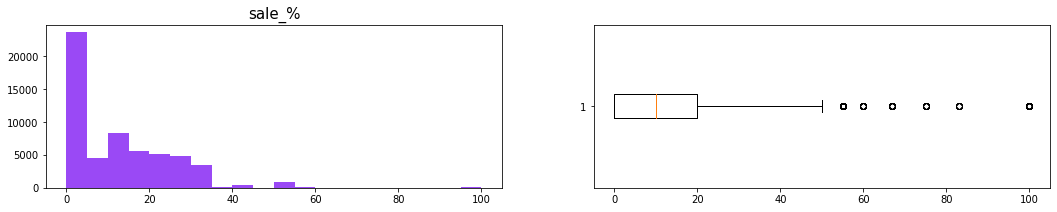

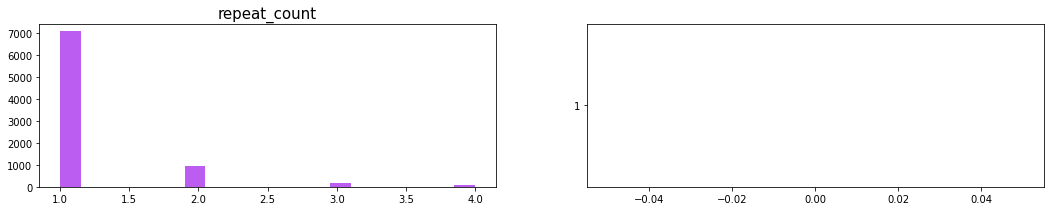

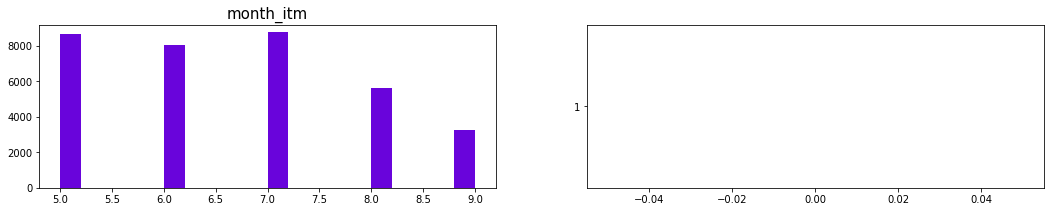

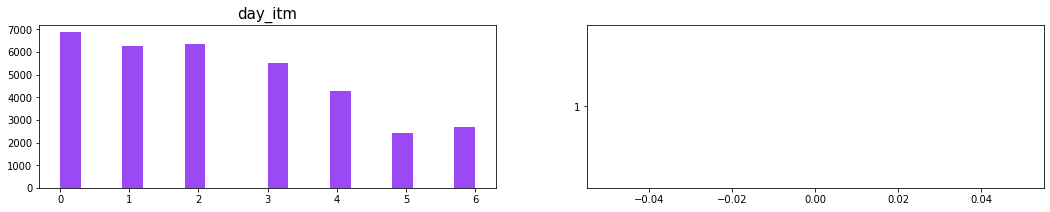

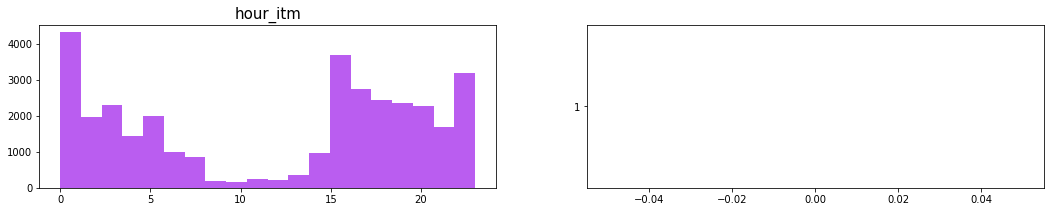

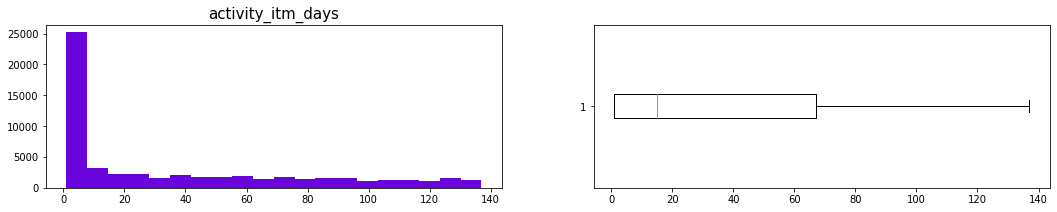

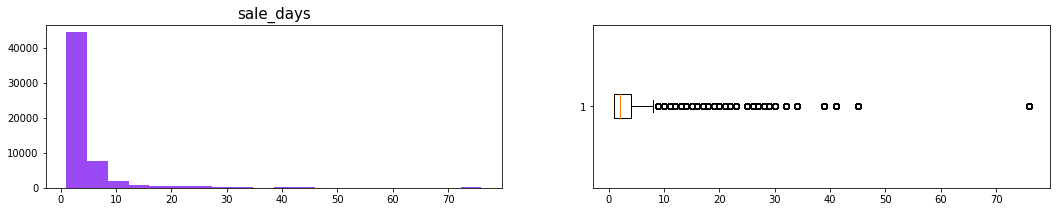

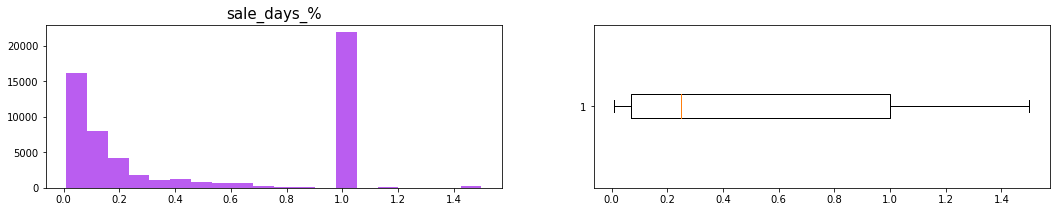

In [756]:
clr_list = ['#6904db', '#9a49f5', '#ba5df0']
    
df_list = [item_features]
for df,feat,clr in zip(cycle(df_list), item_feat_list, cycle(clr_list)):
    feature_distribution(df, feat, clr)

In [757]:
### Preprocessing
#Items list
items_list = item_features.itemid.unique().tolist()

#Selecting properties
items_1 = items_1.loc[items_1.itemid.isin(items_list)]
items_2 = items_2.loc[items_2.itemid.isin(items_list)]

#Concatenating all selected
items = pd.concat([items_1, items_2]).reset_index(drop=True).sort_values(by='itemid')

#Let's check the null values
items.loc[items.value=='0']

,itemid,property,value
267730,15,available,0
321830,15,available,0
212842,17,available,0
453951,19,available,0
317121,25,available,0
...,...,...,...
264320,466736,available,0
211764,466747,available,0
283604,466759,available,0
2495,466796,available,0


In [758]:
#Skip 'available' value
items = items.loc[items.value!='0']

In [759]:
display(tree[tree.categoryid==112])

,categoryid,parentid
1660,112.0,381.0


In [760]:
### Properties concatenation
tree = tree.rename(columns={'categoryid': 'property'})
items = items.loc[(items.property!='categoryid')&(items.property!='available')]
items['property'] = pd.to_numeric(items['property'])
items_full = items.merge(tree, how='left', on='property').fillna(0)
items_full.tail(10)


,itemid,property,value,parentid
528680,466843,839,820477,33.0
528681,466843,764,1285872,1370.0
528682,466843,451,1141052 n49.200 140719 553394,945.0
528683,466843,101,1116693,312.0
528684,466843,917,1107488,1374.0
528685,466843,529,769062,623.0
528686,466843,678,820477,250.0
528687,466843,790,n467880.000,1492.0
528688,466843,681,1078259,8.0
528689,466843,966,n384.000 1187104,1157.0


In [761]:
items_full

,itemid,property,value,parentid
0,15,776,604754,727.0
1,15,790,n8160.000,1492.0
2,15,776,1132786,727.0
3,15,112,679677,381.0
4,15,202,789221,1008.0
...,...,...,...,...
528685,466843,529,769062,623.0
528686,466843,678,820477,250.0
528687,466843,790,n467880.000,1492.0
528688,466843,681,1078259,8.0


In [762]:
#Skip duplicates
items_full = items_full.drop_duplicates()

###Adding properties to all features
items_full.sort_values(by='itemid').head(10)

,itemid,property,value,parentid
0,15,776,604754,727.0
23,15,693,769062,1630.0
22,15,678,245772,250.0
21,15,790,n0.000,1492.0
20,15,283,433564 245772 789221 809278 245772 1213953 429...,1579.0
19,15,790,n7680.000,1492.0
18,15,591,1116693,933.0
17,15,364,1047026,711.0
16,15,812,769062,92.0
14,15,790,n9000.000,1492.0


Как можно видеть, одному itemid может соответствовать несколько неповторяющихся признаков. Чтобы придать признакам уникальность, их можно объеднинить единый строковой объект, который затем обработать при помощи NLP. 

In [763]:
#Selecting unique item IDs
items_df = items_full.loc[items_full.itemid.isin(items_list)]

#Making string features
item_features['property'] = item_features['itemid'].map(get_property)
item_features['value'] = item_features['itemid'].map(get_value)
item_features['parentid'] = item_features['itemid'].map(get_parentid)

In [764]:
item_features

,timestamp,visitorid,event,itemid,transactionid,date,format_date,month,day_week,hour,...,activity_duration_itm,month_itm,day_itm,hour_itm,activity_itm_days,sale_days,sale_days_%,property,value,parentid
0,1433222147345,1076270,view,262799,0.0,2015-06-02 05:15:47.345,2015-06-02 05:15:47.345,6,1,5,...,14 days 16:47:52.539000,6.0,1.0,5.0,15,2,0.13,"{897, 645, 6, 776, 1041, 917, 790, 283, 159, 3...","{695745, 1093697 162918 n30.000, 557711, n24.0...","{1028.0, 145.0, 1181.0, 33.0, 1313.0, 933.0, 1..."
1,1433224644638,361387,view,43485,0.0,2015-06-02 05:57:24.638,2015-06-02 05:57:24.638,6,1,5,...,21 days 07:05:17.274000,6.0,1.0,6.0,22,3,0.14,{},{},{}
2,1433221123646,1076270,view,269430,0.0,2015-06-02 04:58:43.646,2015-06-02 04:58:43.646,6,1,4,...,1 days 05:01:20.429000,NaN,NaN,NaN,2,2,1.00,"{897, 645, 6, 776, 1041, 917, 790, 283, 159, 3...",{1164943 1093697 986387 986387 n24.000 1072114...,"{1028.0, 145.0, 1181.0, 1313.0, 33.0, 933.0, 1..."
3,1433193535886,820159,view,369447,0.0,2015-06-01 21:18:55.886,2015-06-01 21:18:55.886,6,0,21,...,60 days 16:15:08.907000,5.0,0.0,20.0,61,14,0.23,"{771, 776, 1036, 400, 529, 785, 917, 790, 663,...","{992862 1138995, 1318713, 123296 732797 n84.00...","{0.0, 1028.0, 1157.0, 520.0, 8.0, 395.0, 1420...."
4,1433193703544,820159,view,261793,0.0,2015-06-01 21:21:43.544,2015-06-01 21:21:43.544,6,0,21,...,0 days 00:00:00,NaN,NaN,NaN,1,1,1.00,"{6, 776, 268, 917, 790, 538, 283, 542, 159, 92...","{150169 1242195, n24.000 628176 279796 639502 ...","{1028.0, 138.0, 1420.0, 20.0, 1057.0, 933.0, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57206,1438357544346,1188952,addtocart,430566,0.0,2015-07-31 15:45:44.346,2015-07-31 15:45:44.346,7,4,15,...,0 days 00:00:15.426000,NaN,NaN,NaN,1,1,1.00,"{6, 776, 917, 790, 283, 28, 542, 159, 928, 678...","{1289474, 386093 1263557, 1023101 452738, 3860...","{1028.0, 20.0, 33.0, 933.0, 1579.0, 1604.0, 71..."
57207,1438358117670,1188952,addtocart,194328,0.0,2015-07-31 15:55:17.670,2015-07-31 15:55:17.670,7,4,15,...,1 days 00:31:02.705000,NaN,NaN,NaN,2,2,1.00,"{6, 776, 785, 917, 790, 283, 159, 544, 35, 678...","{982599, 992862 951748 1011636, n405720.000, n...","{1028.0, 8.0, 781.0, 1168.0, 145.0, 20.0, 663...."
57208,1438360037777,572806,view,104781,0.0,2015-07-31 16:27:17.777,2015-07-31 16:27:17.777,7,4,16,...,22 days 00:12:23.987000,7.0,3.0,16.0,23,4,0.17,"{6, 776, 917, 790, 283, 159, 33, 678, 689, 698...","{n14040.000, n14280.000, n14880.000, 150169 43...","{1028.0, 33.0, 933.0, 1579.0, 1326.0, 711.0, 1..."
57209,1438406444601,115257,view,443791,0.0,2015-08-01 05:20:44.601,2015-08-01 05:20:44.601,8,5,5,...,0 days 00:00:00,NaN,NaN,NaN,1,1,1.00,"{6, 776, 521, 19, 917, 790, 283, 28, 159, 928,...","{228613, 84421, n11040.000, n13080.000, n10920...","{1028.0, 654.0, 20.0, 540.0, 33.0, 933.0, 1579..."


# 10. Description of Experiments concept

In [765]:
random.seed(77)

In [766]:
#Primary experiment users (1,2,3,4,5 items resp)
pr_exp_users = [291283, 322407, 1214988, 566009, 273406]

In [767]:
#Random 25 users
random_30_users = test.visitorid.unique().tolist()
random_30_users = random.choices(random_30_users, k=30)

In [768]:
random.seed(77)

In [769]:
random_30_users

[1306382,
 751291,
 555511,
 149854,
 271486,
 1058268,
 1214191,
 1340866,
 340182,
 1390774,
 1104300,
 586427,
 68085,
 542702,
 391939,
 1402220,
 1117333,
 374805,
 418867,
 742698,
 217419,
 1152738,
 1167927,
 477566,
 440612,
 202080,
 460599,
 1219487,
 982634,
 588708]

# 11. Baseline (Experiment 0)

Предлагаем каждому пользователю 3 самых популярных товара из списка топ-20 (товары, которые чаще всего покупались большинством пользователей).

In [770]:
#Top_20
cols = ['itemid', 'top_20_sale']
top_20_list = item_features[cols].loc[item_features['top_20_sale']==1]
top_20_list = top_20_list.itemid.unique().tolist()

#3 most popuar items
cols = ['itemid', 'event']
top_20 = user_features[cols].loc[(user_features['event']=='transaction')&(user_features['itemid'].isin(top_20_list))]
supertop_3 = top_20.itemid.value_counts()[0:3].index.tolist()

In [771]:
top_20_list

[334401,
 409804,
 46232,
 140527,
 379953,
 312728,
 301721,
 218794,
 461686,
 92466,
 171878,
 46156,
 444190,
 288525,
 10572,
 213834,
 441852,
 382885,
 445351,
 9877]

In [772]:
supertop_3

[213834, 461686, 445351]

In [773]:
#Experiments & Predictions

#5 fixed users prediction
us_list = pr_exp_users
pred_function = baseline_3_top

baseline_5 = get_prediction(us_list, pred_function)
baseline_5

,visitorid,prediction,purch_number,precision@3
0,291283,0,1,0.0
1,322407,0,1,0.0
2,1214988,0,1,0.0
3,566009,0,1,0.0
4,273406,0,2,0.0


In [774]:
#30 fixed users prediction
us_list = random_30_users
pred_function = baseline_3_top

baseline_30 = get_prediction(us_list, pred_function)
baseline_30

,visitorid,prediction,purch_number,precision@3
0,1306382,0,1,0.0000
1,751291,0,1,0.0000
2,555511,0,1,0.0000
3,149854,0,1,0.0000
4,271486,0,1,0.0000
5,1058268,0,1,0.0000
6,1214191,0,1,0.0000
7,1340866,0,1,0.0000
8,340182,0,1,0.0000
9,1390774,0,1,0.0000


In [775]:
mean_precision = round((baseline_30['precision@3'].mean()),2)
print('Baseline experiment precision mean: ', mean_precision)

Baseline experiment precision mean:  0.01


На случайной выборке из 30 пользователей с применением бейзлайна мы получили следующую метрику -
- precision@3 - 0.01

Это не достаточно высокий показатель (простое предложение топ товаров работает не всегда :)) и мы надеемся улучшить его в последующих экспериментах.

 ## 12. Cosine Similarity (Experiment 1)

Эксперимент состоит из 2 частей - генерация кандидатов на основе оценки сходства векторов пользователей и сходства веторов товаров.


### VISITORS matrix

1. Построение матрицы для отбора пользователей со схожим паттерном потребительского методом Cosine similarity.
2. Генерация айтемов-кандидатов: в выборку войдут все товары, которые были куплены похожими пользователями.
3. Двойная фильтрация кандидатов: 
- история взаимодействия с товарами похожих пользователей из выборки (сколько раз просматривали, покупали и т.д.), 
- история взаимодействия с товарами пользователя, для которого делается рекомендация (основного пользователя).

При этом оценка ставится по количеству действий каждого типа, совершенных пользователями - 1 балл просмотр, 2 балла - добавление в корзину, 5 баллов - покупка.

- сложение рейтинга похожих пользователей с рейтингом основного пользователя и последующаях сортировка.

In [776]:
user_features[['repeat_count', 'top_20_purch', 'month_top_purch']] = user_features[['repeat_count', 'top_20_purch', 'month_top_purch']].fillna(0)

In [777]:
#Selecting unique visitor's features for the next vectorisation
#Features lists
unique_user_features_cos = user_features.columns.to_list()[10:]
unique_user_features_cos_str = unique_user_features_cos
unique_user_features_cos = ['visitorid']+unique_user_features_cos#VISITORS df for vectorisation and cosine similarity counting
cos_VISITORS_df = user_features[unique_user_features_cos].drop_duplicates()

#Features in 'str' format for the next vectorisation
for column in cos_VISITORS_df[unique_user_features_cos_str]:
        cos_VISITORS_df[column+"_str"] = cos_VISITORS_df[column].astype('str') 
        
#Drop NOT str
cos_VISITORS_df.drop(columns=unique_user_features_cos_str, axis=1, inplace=True)

#Reset index
cos_VISITORS_df = cos_VISITORS_df.reset_index(drop=True)

#Visitor-index frame
user_index_cos = cos_VISITORS_df.visitorid.to_frame()

#Drop visitors from the main frame
cos_VISITORS_df.drop(columns='visitorid', axis=1, inplace=True)

In [778]:
#Making combined STR feature for vector
columns_counter = len(cos_VISITORS_df.columns.to_list())-1

cos_VISITORS_df['combined'] = ''
for i in range(columns_counter):
    cos_VISITORS_df['combined'] = cos_VISITORS_df['combined']+cos_VISITORS_df[cos_VISITORS_df.columns[i]]

In [779]:
cos_VISITORS_df = user_index_cos.merge(cos_VISITORS_df['combined'], left_index=True, right_index=True)

In [780]:
cos_VISITORS_df.head()

,visitorid,combined
0,1076270,3218239.09.01.55.01.02.00.00.00.02015-06-02 04...
1,361387,02121414.06.00.05.50.01.01.00.00.02015-06-02 0...
2,820159,751471593.029.41.413.81.01.250.00.00.02015-06-...
3,38015,324854900.0242.51.560.01.01.00.00.00.02015-05-...
4,273406,76223517.03.671.172.331.06.00.01.00.02015-06-0...


In [781]:
#Modelling
###Matrix
cv = CountVectorizer()
count_VISITORS_matrix = cv.fit_transform(cos_VISITORS_df['combined'])
print("Count Matrix:", count_VISITORS_matrix.toarray())

Count Matrix: [[4 0 0 ... 0 0 1]
 [4 0 0 ... 0 0 1]
 [2 0 0 ... 0 0 1]
 ...
 [5 0 0 ... 0 0 1]
 [6 0 0 ... 0 0 1]
 [4 0 0 ... 0 0 1]]


In [782]:
###Cosine Similarity
cosine_sim_vis = cosine_similarity(count_VISITORS_matrix)

In [783]:
#Prediction on fixed 5 visitors
us_list = pr_exp_users
pred_function = cos_vis_items
get_prediction(us_list, pred_function)

,visitorid,prediction,purch_number,precision@3
0,291283,0,1,0.0
1,322407,0,1,0.0
2,1214988,0,1,0.0
3,566009,0,1,0.0
4,273406,0,2,0.0


In [784]:
#Prediction on 30 random visitors
us_list = random_30_users
pred_function = cos_vis_items
cos_users_items = get_prediction(us_list, pred_function) #frame
display(cos_users_items)

,visitorid,prediction,purch_number,precision@3
0,1306382,0,1,0.0000
1,751291,0,1,0.0000
2,555511,0,1,0.0000
3,149854,0,1,0.0000
4,271486,0,1,0.0000
5,1058268,0,1,0.0000
6,1214191,0,1,0.0000
7,1340866,0,1,0.0000
8,340182,0,1,0.0000
9,1390774,0,1,0.0000


In [785]:
mean_precision = round((cos_users_items['precision@3'].mean()),2)
print('Cosine similarity collaborative filtration (users) experiment precision mean: ', mean_precision)

Cosine similarity collaborative filtration (users) experiment precision mean:  0.01


### Комментарий:

На случайной выборке из 30 пользователей с применением коллаборативной фильтрации по пользователям (оценка близости векторов методом Cosine similarity) мы получили следующую метрику -
- precision@3 0.01

Метрика пока не изменилась

### ITEMS matrix

1. Построение матрицы для отбора товаров схожих с приобретенными основным пользователем на основе сходства векторов методом Cosine similarity.
2. Тройная фильтрация кандидатов:
- Cosine similarity
- история взаимодейтсвия с товарами-кандидатами всех пользователей датасета,
- история взаимодействия с товарами пользователя, для которого делается рекомендация,
- сложение рейтингов и последующая сотировка по рейтингу и Similarity score.

In [786]:
item_features.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid', 'date',
       'format_date', 'month', 'day_week', 'hour', 'add_item', 'trans_item',
       'view_item', 'all_events_itm', 'sale_%', 'repeat_count', 'top_20_sale',
       'top_month_sale', 'first_date_itm', 'last_date_itm',
       'activity_duration_itm', 'month_itm', 'day_itm', 'hour_itm',
       'activity_itm_days', 'sale_days', 'sale_days_%', 'property', 'value',
       'parentid'],
      dtype='object')

Товары, которые ни разу за историю наблюдений в TRAIN не были куплены, скорее всего не будут популярны и в дальнейшем, поэтому удаляем их.

In [787]:
#Selecting unique item's features for the next vectorisation
#Features lists
unique_item_features_cos = item_features.columns.to_list()[10:]
unique_item_features_cos_str = unique_item_features_cos
unique_item_features_cos = ['itemid']+unique_item_features_cos

In [788]:
cos_ITEMS_df = item_features[unique_item_features_cos]
#Filling NAN's
cos_ITEMS_df[['repeat_count', 'top_20_sale', 'top_month_sale']] = cos_ITEMS_df[['repeat_count', 'top_20_sale', 'top_month_sale']].fillna(0)
#Selecting only purchased items
cos_ITEMS_df = cos_ITEMS_df.loc[cos_ITEMS_df.trans_item!=0]
#Trasform to str SET values
cols = ['property', 'value', 'parentid']
cos_ITEMS_df['property_str'] = cos_ITEMS_df['property'].apply(lambda x: str(x))
cos_ITEMS_df['value_str'] = cos_ITEMS_df['value'].apply(lambda x: str(x))
cos_ITEMS_df['parentid_str'] = cos_ITEMS_df['parentid'].apply(lambda x: str(x))

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [789]:
cos_ITEMS_df['property_str_fixed'] = cos_ITEMS_df['property_str'].apply(lambda x: '-' if x=='set()' else x)
cos_ITEMS_df['value_str_fixed'] = cos_ITEMS_df['value_str'].apply(lambda x: '-' if x=='set()' else x)
cos_ITEMS_df['parentid_str_fixed'] = cos_ITEMS_df['parentid_str'].apply(lambda x: '-' if x=='set()' else x)

In [790]:
#Dropping unnecessary columns
drop_cols = cos_ITEMS_df.columns[18:-3].to_list()
cos_ITEMS_df.drop(columns=drop_cols, axis=1, inplace=True)

#Rename cols for the next transforming
cos_ITEMS_df = cos_ITEMS_df.rename(columns={'property_str_fixed': 'property',
                                            'value_str_fixed': 'value',
                                            'parentid_str_fixed': 'parentid'})

In [791]:
#ITEMS df for vectorisation and cosine similarity counting
cos_ITEMS_df = cos_ITEMS_df.drop_duplicates() 

#Features in 'str' format for the next vectorisation
for column in cos_ITEMS_df.columns:
        cos_ITEMS_df[column+"_str"] = cos_ITEMS_df[column].astype('str') 
        
#Drop NOT str
cos_ITEMS_df.drop(columns=unique_item_features_cos_str, axis=1, inplace=True)

#Reset index
cos_ITEMS_df = cos_ITEMS_df.reset_index(drop=True)

#Visitor-index frame
item_index_cos = cos_ITEMS_df.itemid.to_frame()

#Drop items from the main frame
item_cols = ['itemid', 'itemid_str']
cos_ITEMS_df.drop(columns=item_cols, axis=1, inplace=True)

In [792]:
item_index_cos

,itemid
0,262799
1,43485
2,369447
3,351798
4,399053
...,...
4618,32384
4619,246766
4620,151668
4621,152236


In [793]:
#Making combined STR feature for vector
columns_counter = len(cos_ITEMS_df.columns.to_list())-1

cos_ITEMS_df['combined'] = ''
for i in range(columns_counter):
    cos_ITEMS_df['combined'] = cos_ITEMS_df['combined']+cos_ITEMS_df[cos_ITEMS_df.columns[i]]

In [794]:
#Adding items
cos_ITEMS_df = item_index_cos.merge(cos_ITEMS_df['combined'], left_index=True, right_index=True)
cos_ITEMS_df.head()

,itemid,combined
0,262799,115714.00.00.00.02015-06-02 05:11:59.1302015-0...
1,43485,02111315.01.00.00.02015-05-12 17:46:40.3532015...
2,369447,55344411.00.00.01.02015-05-04 04:02:56.4662015...
3,351798,011250.00.00.00.02015-06-01 16:18:37.3602015-0...
4,399053,03101323.00.00.00.02015-05-05 05:13:11.3232015...


In [795]:
#Modelling
###Matrix
cv = CountVectorizer()
count_ITEMS_matrix = cv.fit_transform(cos_ITEMS_df['combined'])
print("Count Matrix:", count_ITEMS_matrix.toarray())

Count Matrix: [[ 3 25  0 ...  0  0  0]
 [ 3  0  0 ...  0  0  0]
 [ 3 28  0 ...  0  0  0]
 ...
 [ 4 20  0 ...  0  0  0]
 [ 4 18  0 ...  0  0  0]
 [ 4  8  0 ...  0  0  0]]


In [796]:
###Cosine Similarity
cosine_sim_itm = cosine_similarity(count_ITEMS_matrix)

In [797]:
#Prediction on fixed 5 visitors
us_list = pr_exp_users
pred_function = cos_items_items
get_prediction(us_list, pred_function)

,visitorid,prediction,purch_number,precision@3
0,291283,0,1,0.0
1,322407,0,1,0.0
2,1214988,0,1,0.0
3,566009,0,1,0.0
4,273406,0,2,0.0


In [798]:
#Prediction on 30 random visitors
us_list = random_30_users
pred_function = cos_items_items
get_prediction(us_list, pred_function)
pred_df = get_prediction(us_list, pred_function)
display(pred_df)

,visitorid,prediction,purch_number,precision@3
0,1306382,0,1,0.0000
1,751291,0,1,0.0000
2,555511,1,1,0.3333
3,149854,0,1,0.0000
4,271486,1,1,0.3333
5,1058268,0,1,0.0000
6,1214191,0,1,0.0000
7,1340866,0,1,0.0000
8,340182,0,1,0.0000
9,1390774,0,1,0.0000


In [799]:
mean_precision = round((pred_df['precision@3'].mean()),2)
print('Cosine similarity collaborative filtration (items) experiment precision mean: ', mean_precision)

Cosine similarity collaborative filtration (items) experiment precision mean:  0.06


На случайной выборке из 30 пользователей с применением коллаборативной фильтрации по товарам (оценка близости векторов методом Cosine similarity) мы получили следующую метрику -
- precision@3 - 0.06

Метрики явно улучшилась

# 13. Logistic Matrix Factorization (Experiment 2)
### 13.1. Item-User Matrix building

In [800]:
#Import
from scipy.sparse import coo_matrix

In [801]:
#Let's calculate the rating for every item and user
cols = ['itemid', 'visitorid', 'event']
score_dict = {'transaction': 5,
              'addtocart': 2,
              'view': 1}


#Select only purchased items
purchased_items = user_features[['event', 'itemid']].loc[user_features.event=='transaction']
purchased_items = purchased_items.itemid.unique().tolist()

#Building matrix
item_user_matrix = user_features[cols].loc[user_features.itemid.isin(purchased_items)]
item_user_matrix['rating'] = item_user_matrix['event'].map(score_dict)
item_user_matrix = pd.pivot_table(item_user_matrix,
                                  values = 'rating',
                                  index = 'itemid',
                                  columns= 'visitorid',
                                  aggfunc=np.sum, fill_value=0)

item_user_matrix.head()

visitorid,172,264,2019,3104,3258,3465,3926,4101,4537,4606,...,1398505,1398811,1398978,1400296,1401333,1402220,1403769,1404265,1404991,1406087
itemid,,,,,,,,,,,,,,,,,,,,,
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [802]:
item_user_matrix.shape

(4623, 2438)

In [803]:
#Item indices
item_index = item_user_matrix.index.to_frame().reset_index(drop=True)
item_index = item_index.reset_index()

In [804]:
#User indices
user_index = item_user_matrix.columns.T.to_frame().reset_index(drop=True)
user_index = user_index.rename(columns={'itemid': 'visitorid'})
user_index = item_index.reset_index()

In [805]:
item_index

,index,itemid
0,0,15
1,1,19
2,2,25
3,3,42
4,4,147
...,...,...
4618,4618,466114
4619,4619,466161
4620,4620,466319
4621,4621,466321


In [806]:
#User indices
user_index = item_user_matrix.columns.T.to_frame().reset_index(drop=True)
user_index = user_index.reset_index()

In [807]:
user_index

,index,visitorid
0,0,172
1,1,264
2,2,2019
3,3,3104
4,4,3258
...,...,...
2433,2433,1402220
2434,2434,1403769
2435,2435,1404265
2436,2436,1404991


In [808]:
#Coo_matrix for factorization
item_user_coo = scipy.sparse.coo_matrix(item_user_matrix)

In [809]:
item_user_coo

<4623x2438 sparse matrix of type '<class 'numpy.int64'>'
	with 10951 stored elements in COOrdinate format>

In [810]:
#User_items matrix for predictions
user_item_sparse = sparse.csr_matrix(item_user_matrix.T)

In [811]:
user_item_sparse

<2438x4623 sparse matrix of type '<class 'numpy.int64'>'
	with 10951 stored elements in Compressed Sparse Row format>

In [812]:
# Initialize the model and fit it using the sparse item-user matrix
model = implicit.lmf.LogisticMatrixFactorization(factors=20, regularization=0.1, iterations=20, neg_prop=5)
model.fit(item_user_coo)

100%|██████████| 20/20 [00:00<00:00, 209.25it/s]


In [813]:
model

In [814]:
#Prediction on fixed 5 visitors
us_list = pr_exp_users
pred_function = simple_mtrx_user
get_prediction(us_list, pred_function)

,visitorid,prediction,purch_number,precision@3
0,291283,0,1,0.0
1,322407,0,1,0.0
2,1214988,0,1,0.0
3,566009,0,1,0.0
4,273406,0,2,0.0


In [815]:
#Prediction on 30 random visitors
us_list = random_30_users
pred_function = cos_items_items
get_prediction(us_list, pred_function)
pred_df = get_prediction(us_list, pred_function)
display(pred_df)

,visitorid,prediction,purch_number,precision@3
0,1306382,0,1,0.0000
1,751291,0,1,0.0000
2,555511,1,1,0.3333
3,149854,0,1,0.0000
4,271486,1,1,0.3333
5,1058268,0,1,0.0000
6,1214191,0,1,0.0000
7,1340866,0,1,0.0000
8,340182,0,1,0.0000
9,1390774,0,1,0.0000


In [816]:
mean_precision = round((pred_df['precision@3'].mean()),2)
print('Simple Logistic Matrix Factorization (users) experiment precision mean: ', mean_precision)

Simple Logistic Matrix Factorization (users) experiment precision mean:  0.06


### Комментарий:

На случайной выборке из 30 пользователей с применением логистической матричной факторизации (простое функциональное предсказание) мы получили следующие метрики -
- precision@3 - 0.06

Метрика не изменилась



## Similar VISITORS prediction¶

In [817]:
#Prediction on fixed 5 visitors
us_list = pr_exp_users
pred_function = mtrx_vis_items
get_prediction(us_list, pred_function)

,visitorid,prediction,purch_number,precision@3
0,291283,1,1,0.3333
1,322407,1,1,0.3333
2,1214988,1,1,0.3333
3,566009,1,1,0.3333
4,273406,1,2,0.3333


In [818]:
#Prediction on 30 random visitors
us_list = random_30_users
pred_function = mtrx_vis_items
get_prediction(us_list, pred_function)
pred_df = get_prediction(us_list, pred_function)
display(pred_df)

,visitorid,prediction,purch_number,precision@3
0,1306382,1,1,0.3333
1,751291,1,1,0.3333
2,555511,1,1,0.3333
3,149854,1,1,0.3333
4,271486,1,1,0.3333
5,1058268,1,1,0.3333
6,1214191,1,1,0.3333
7,1340866,1,1,0.3333
8,340182,1,1,0.3333
9,1390774,1,1,0.3333


In [819]:
mean_precision = round((pred_df['precision@3'].mean()),2)
print('Users collabirative filtering Logistic Matrix Factorization (users) experiment precision mean: ', mean_precision)


Users collabirative filtering Logistic Matrix Factorization (users) experiment precision mean:  0.33


Коллаборативная фильтрация по пользователям на основании логистической матричной факторизации с последующим отборов лучших товаров на основе рейтинга дала кардинальное улучшение метрики -   
- precision@3: 0.33

Продолжим эксперимент и выполним коллаборативную фильтрацию по товарам.

## Similar ITEMS prediction

In [820]:
#Prediction by similar ITEMS generation (Logistic Matrix Factorization)
def mtrx_items_items(num):
    
    ### 1. Similar items from matrix
    purchased_items = item_features.loc[(item_features.visitorid==num)&(item_features.event=='transaction')]['itemid'].to_list()
    purchased_item_indices = item_index.loc[item_index.itemid.isin(purchased_items)].index.tolist()
    
    #Items list iteration
    iteration_range = len(purchased_item_indices)
    frame = pd.DataFrame()

    for i in range(iteration_range):
        similar_items = model.similar_items(itemid = purchased_item_indices[i], N=5)
        similar_items = pd.DataFrame(similar_items, columns=['index', 'score'])        
        items_list = []
        for j in similar_items['index']:
                itemid = item_index.iloc[j][1]
                items_list.append(itemid)
                similar_items['itemid'] = pd.DataFrame(items_list)                
        frame = pd.concat([frame,similar_items])
            
    frame = frame.groupby(by='itemid').sum().reset_index()[['itemid', 'score']]
    frame = frame.rename(columns={'score': 'similarity_score'})
    similarity_frame = frame
    
    ### 2. Items filtering by rating
    # 2.1.  All users events filter / как все пользователи взаимодействовали с этими товарами
    similar_items = similarity_frame.itemid.unique().tolist()
    
    cols = ['itemid','add_item', 'trans_item', 'view_item', 'repeat_count', 'top_20_sale', 'top_month_sale']
    common_items_rating = item_features[cols].loc[item_features.itemid.isin(similar_items)]
    common_items_rating['add_scores'] = common_items_rating['add_item']*2
    common_items_rating['view_scores'] = common_items_rating['view_item']
    common_items_rating['trans_scores'] = common_items_rating['trans_item']*5
    common_items_rating['repeat_scores'] = common_items_rating['repeat_count']*10
    common_items_rating['top_scores'] = (common_items_rating['top_20_sale']+common_items_rating['top_month_sale'])*10
    common_items_rating = common_items_rating.drop_duplicates().fillna(0).reset_index(drop=True)
    score_cols = common_items_rating.columns[7:]
    common_items_rating['score'] = common_items_rating[score_cols].sum(axis=1)
    
    # 2.3. User's rating / как пользователь взаимодействовал с товарами
    cols = ['visitorid', 'itemid', 'event']

    score_dict = {'transaction': 25,
              'addtocart': 10,
              'view': 5}

    sing_vis_items_rating = user_features[cols]
    sing_vis_items_rating = sing_vis_items_rating.loc[(sing_vis_items_rating.visitorid==num)&(
                                                  sing_vis_items_rating.itemid.isin(similar_items))] #frame

    sing_vis_items_rating['score'] = sing_vis_items_rating['event'].map(score_dict)

    sing_vis_items_rating = pd.pivot_table(sing_vis_items_rating,
                        values = 'score', 
                        index = ['itemid'],
                        aggfunc=np.sum)

    sing_vis_items_rating = sing_vis_items_rating.reset_index()
    
    #3.3. Final rating (similar items + desired visitor + similarity)
    common_rating = common_items_rating.merge(sing_vis_items_rating, on='itemid', how='left')

    columns_count = common_rating.shape[1]

    if columns_count==13:
        common_rating['sing_score']=0
    else:
        common_rating['sing_score']=common_rating['score_y']
    
    common_rating['final'] = common_rating[common_rating.columns[12]]+common_rating['sing_score']
    
    #Adding similarity score
    common_rating = common_rating.merge(similarity_frame, on='itemid', how='left')
    cols = ['itemid', 'similarity_score', 'final']
    common_rating = common_rating[cols]
    common_rating = common_rating.sort_values(by=['final', 'similarity_score'], ascending=False)
    
    #Predicted items
    pred_items_user = common_rating.itemid[0:3].to_list()

    ### 4. Prediction checking
    prediction = set(pred_items_user)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict 

In [821]:
#Prediction on fixed 5 visitors
us_list = pr_exp_users
pred_function = mtrx_items_items
get_prediction(us_list, pred_function)

,visitorid,prediction,purch_number,precision@3
0,291283,1,1,0.3333
1,322407,1,1,0.3333
2,1214988,1,1,0.3333
3,566009,1,1,0.3333
4,273406,1,2,0.3333


In [822]:
#Prediction on 30 random visitors
us_list = random_30_users
pred_function = mtrx_items_items
get_prediction(us_list, pred_function)
pred_df = get_prediction(us_list, pred_function)
display(pred_df)

,visitorid,prediction,purch_number,precision@3
0,1306382,1,1,0.3333
1,751291,1,1,0.3333
2,555511,1,1,0.3333
3,149854,0,1,0.0000
4,271486,1,1,0.3333
5,1058268,1,1,0.3333
6,1214191,1,1,0.3333
7,1340866,1,1,0.3333
8,340182,1,1,0.3333
9,1390774,1,1,0.3333


In [823]:
mean_precision = round((pred_df['precision@3'].mean()),2)
print('Items collaborative filtering Logistic Matrix Factorization (users) experiment precision mean: ', mean_precision)

Items collaborative filtering Logistic Matrix Factorization (users) experiment precision mean:  0.32


Коллаборативная фильтрация по товарам на основе логистической матричной факторизации дала несколько худший, чем предыдущий эксперимент, результат -
- precision@3: 0.32

# 14. Best version

Двухстадийная рекомендация на основе коллаборативной фильтрации при помощи Logistic Matrix Factorization.

In [824]:
#Random 30 visitors
random_30_users = test.visitorid.unique().tolist()
random_30_users = random.choices(random_30_users, k=30)

In [825]:
### Matrix
#Let's calculate the rating for every item and user
cols = ['itemid', 'visitorid', 'event']
score_dict = {'transaction': 5,
              'addtocart': 2,
              'view': 1}


#Select only purchased items
purchased_items = user_features[['event', 'itemid']].loc[user_features.event=='transaction']
purchased_items = purchased_items.itemid.unique().tolist()

#Building matrix
item_user_matrix = user_features[cols].loc[user_features.itemid.isin(purchased_items)]
item_user_matrix['rating'] = item_user_matrix['event'].map(score_dict)
item_user_matrix = pd.pivot_table(item_user_matrix,
                                  values = 'rating',
                                  index = 'itemid',
                                  columns= 'visitorid',
                                  aggfunc=np.sum, fill_value=0)



#Item indices
item_index = item_user_matrix.index.to_frame().reset_index(drop=True)
item_index = item_index.reset_index()

#User indices
user_index = item_user_matrix.columns.T.to_frame().reset_index(drop=True)
user_index = user_index.reset_index()

#Coo_matrix for factorization
item_user_coo = scipy.sparse.coo_matrix(item_user_matrix)

#User_items matrix for predictions
user_item_sparse = sparse.csr_matrix(item_user_matrix.T)

In [826]:
### Modelling

# Initialize the model and fit it using the sparse item-user matrix
model = implicit.lmf.LogisticMatrixFactorization(factors=20, regularization=0.1, iterations=20, neg_prop=5)
model.fit(item_user_coo)

100%|██████████| 20/20 [00:00<00:00, 207.31it/s]


In [827]:
### Prediction function

#Prediction by similar USERS generation (Logistic Matrix Factorization)

def mtrx_vis_items(num):
    
    ### 1. Similar users from matrix
    #Index for desired user
    num = pr_exp_users[0]
    usr = user_index.loc[user_index.visitorid==num]['index'].iloc[0]
    #Similar users generation (5 users)
    similar_users = model.similar_users(userid=usr, N=5)
    similar_users = pd.DataFrame(similar_users, columns=['us_index', 'score'])
    #Indices list
    users_index_list = similar_users.us_index.tolist()
    similar_visitors = user_index.loc[user_index.index.isin(users_index_list)]
    similar_visitors = similar_visitors.visitorid.to_list()
        
    ### 2. Items generation
    
    cols = ['visitorid', 'itemid', 'event']
    purchased_items = user_features[cols]
    purchased_items = purchased_items.loc[(purchased_items.event=='transaction')&(purchased_items.visitorid.isin(similar_visitors))]
    purchased_items = purchased_items.itemid.unique().tolist() #unique items
    
    ### 3. Items filtering by rating
    #3.1. Similar users rating
    cols = ['visitorid', 'itemid', 'event']
    vis_items_rating = user_features[cols]
    cols = ['visitorid', 'itemid', 'event']
    sim_vis_items_rating = user_features[cols]
    sim_vis_items_rating = sim_vis_items_rating.loc[(sim_vis_items_rating.visitorid.isin(similar_visitors))&(
                                                     sim_vis_items_rating.itemid.isin(purchased_items))]
    
    score_dict = {'transaction': 5,
                  'addtocart': 2,
                  'view': 1}
    sim_vis_items_rating['score'] = sim_vis_items_rating['event'].map(score_dict)

    sim_vis_items_rating = pd.pivot_table(sim_vis_items_rating,
                        values = 'score', 
                        index = ['visitorid', 'itemid'],
                        aggfunc=np.sum)
    sim_vis_items_rating = sim_vis_items_rating.reset_index() #initial users rating
    
    #3.2. Desired visitor's backlog rating    
    sing_vis_items_rating = user_features[cols]
    sing_vis_items_rating = sing_vis_items_rating.loc[(sing_vis_items_rating.visitorid==num)&(
                                                 sing_vis_items_rating.itemid.isin(purchased_items))]

    sing_vis_items_rating['score'] = sing_vis_items_rating['event'].map(score_dict)

    sing_vis_items_rating = pd.pivot_table(sing_vis_items_rating,
                        values = 'score', 
                        index = ['itemid'],
                        aggfunc=np.sum)

    sing_vis_items_rating = sing_vis_items_rating.reset_index()
    
    #3.3. Final rating (similar users + desired visitor)
    common_rating = sim_vis_items_rating.merge(sing_vis_items_rating, on='itemid', how='left')

    columns_count = common_rating.shape[1]

    if columns_count==3:
        common_rating['sing_score']=0
    else:
        common_rating['sing_score']=common_rating['score_y']
    
    common_rating['final'] = common_rating[common_rating.columns[2]]+common_rating['sing_score']
    common_rating = common_rating.sort_values(by='final', ascending=False)
    pred_items_user = common_rating[0:3]['itemid'].to_list()

    ### 4. Prediction checking
    prediction = set(pred_items_user)
    check = set(test.loc[test.visitorid==num]['itemid'].to_list())
    verdict = len(prediction.intersection(check))
    
    return verdict

In [828]:
### Prediction
#Prediction on 30 random visitors
us_list = random_30_users
pred_function = mtrx_vis_items
get_prediction(us_list, pred_function)
pred_df = get_prediction(us_list, pred_function)
display(pred_df)

,visitorid,prediction,purch_number,precision@3
0,1306382,1,1,0.3333
1,751291,1,1,0.3333
2,555511,1,1,0.3333
3,149854,1,1,0.3333
4,271486,1,1,0.3333
5,1058268,1,1,0.3333
6,1214191,1,1,0.3333
7,1340866,1,1,0.3333
8,340182,1,1,0.3333
9,1390774,1,1,0.3333


In [829]:
mean_precision = round((pred_df['precision@3'].mean()),2)
print('Users collaborative filtering Logistic Matrix Factorization (users) experiment precision mean: ', mean_precision)


Users collaborative filtering Logistic Matrix Factorization (users) experiment precision mean:  0.33


Вывод:

Обзор исходных данных говорит о том, что значительная часть продаж приходится на сезонные бестселлеры, продающиеся в определенные часы и дни. Анализ паттерна поведения покупателей приводит к выводу: часто эти покупки бывают единичными и покупатели приходят в систему только за ними (превалируют короткие периоды активности в системе, низкая комплексность покупок). Большое количество единичных покупок от разных покупателей создает дополнительные сложности при анализе их истории взаимодействия с товарами и генерации рекомендаций на этой базе. 

Поэтому для построения экспериментов было решено взять за основу одну из систрем рекмендаций Google, Two Towers (https://medium.com/@rubenszimbres/train-and-deploy-google-clouds-two-towers-recommender-3ae5c29891af). Вкратце ее структура такова:

- определение похожих на исходного user пользователей и отбор товаров-кандидатов по их истории покупок с последующей фильтрацией (Башня 1)
- генерация товаров-кандидатов на основе истории покупок или рейтингов пользователя (Башня 2)
- определение пересечений в результатах двух предыдущих отборов (dot-item)

Однако практические попытки построить такую систему на основе исходного датасета показали, что при большом количестве единичных покупок редко генерируются пересекающиеся множества товаров при коллаборативной фильтрации по пользователям и по товарам. Поэтому генерация кандидатов на основе пользователей и товаров были рассмотрены как самостоятельные эксперименты.

В итоге, коллаборативная фильтрация по пользователям на основании логистической матричной факторизации с последующим отборов лучших товаров на основе рейтинга является лучшей из рассмотренных моделей
